In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize 
import generate_data
import economic_analysis
import optimization
from importlib import reload 
import pandas as pd
import json

# <font color = 'yellow' > To - Do </font>

0. Convert param files to JSON
1. Get a (non-linear) equation for battery degradation as function of age and total energy throughput <font color = 'orange'> Ask Becky for this </font>
2. Make battery efficiency non-linear for state of charge above 85% <font color = 'orange'> (CURRENTLY working on this, ask brendan for paper) </font>  </br>
2b. Ask Becky, Volkan or Malcolm what a and b are

In [172]:
battery_max_energy_throughput = generate_data.get_battery_max_energy_throughput(100, a)
battery_energy_throughput = 50000
degradation = 1 / (1 + np.exp((battery_max_energy_throughput - battery_energy_throughput) / 400))
degradation


/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_71462/2874808193.py:3: RuntimeWarning: overflow encountered in exp
  degradation = 1 / (1 + np.exp((battery_max_energy_throughput - battery_energy_throughput) / 400))


0.0

# Get load shedding profiles

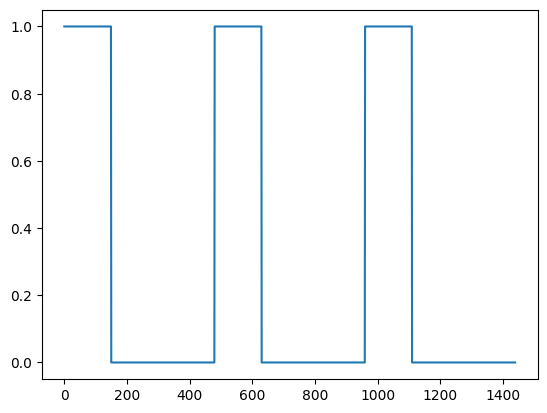

In [11]:
ls_0 = [(0, 150), (480, 630), (960, 1110)]		
ls_1 = [(120, 270), (600, 750), (1080, 1230)]
ls_2 = [(240, 390), (720, 870), (1200, 1350)]
ls_3 = [(360, 510), (840, 990), (1320, 1470)]

def generate_loadshedding_profile(ls: list):
    schedule = [False] * 1440  # create a list of 1440 zeros (one for each minute in a day)
    for start, end in ls:
        for i in range(start, end):
            schedule[i] = True  # set the corresponding minute to True (indicating loadshedding)
    return schedule
    

plt.plot(generate_loadshedding_schedule(ls_0))



## Generate Data

### Simulate charging load and insolation profiles

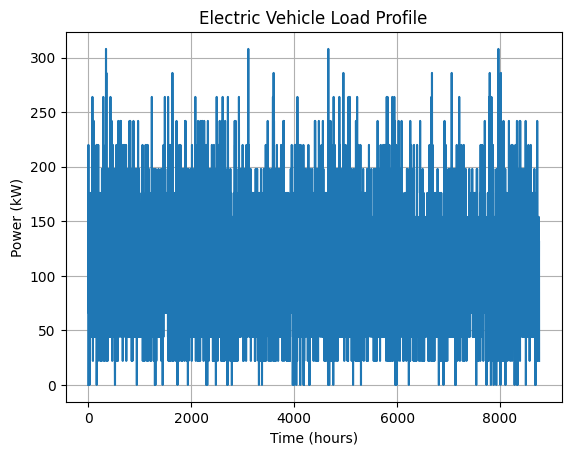

In [2]:
total_days = 365  # Total number of days to simulate
total_time = 24 * total_days  # Total simulation time in hours
time_resolution = 1  # Time resolution in hours (e.g., 0.25 means 15 minutes)
num_vehicles = 47  # Number of EVs in the simulation
charging_power = 22  # Charging power in kW (e.g., Level 2 charging)
load_profile_simulated = generate_data.simulate_charging_load_profile(total_days, total_time,time_resolution, num_vehicles, charging_power)

In [3]:
# Generate equivalent ICE vehicle cost based on kWh utilization
vehicle_kWh_km = 0.2 # kWh/km
vehicle_km_per_year = load_profile_simulated.sum() * vehicle_kWh_km
fuel_cost = 1.5 # $/L
fuel_economy = 6.0 # L/100km
ICE_fuel_cost_per_year = fuel_cost * fuel_economy * vehicle_km_per_year / 100 



#### Getting charging profile from Jacques data

In [4]:
class chargingStation:
    def __init__(self):
        self.charging_power = 7
        self.charging_efficiency = 0.95
        self.discharging_efficiency = 0.95
        self.battery_capacity = 40
        self.battery_duration = 6
        
        
def read_json(filepath):
    f = open(filepath)
    data = json.load(f)
    f.close()
    return data
        

def retrieve_all_vehicle_data(df_data):
    keys = ['time', 'duration', 'end_point', 'end_soc', 'soc_per_min', 'mode', 'distance', 'start_point', 'trip_num', 'lateness']

    # Use list comprehensions to extract values for each key and handle missing keys with np.nan
    values = [[item.get(key, np.nan) for key in keys] for item in df_data]

    # Create the DataFrame using the zipped lists
    df = pd.DataFrame(values, columns=keys)
    return df



def get_charging_profile(df):
    df = df[1:]
    df['soc_per_min'] = np.where(df['mode'] != 'charging', 0, df['soc_per_min'])
    
    # Create an empty dataframe with 1440 rows and a 'kWh_charged' column
    df_minute = pd.DataFrame({'kWh_charged': np.nan}, index=range(1440))

    # Iterate over each row in the original dataframe
    for _, row in df.iterrows():
        
        start_minute = int(row['time'])  # Starting minute of charging
        end_minute = start_minute + int(row['duration'])  # Ending minute of charging
    
        # Assign the 'soc_per_min' value to the corresponding minutes in the new dataframe
        df_minute.loc[start_minute:end_minute, 'kWh_charged'] = row['soc_per_min']

    # Fill any remaining NaN values with 0
    df_minute.fillna(0, inplace=True)

    return df_minute


def get_cumulative_charging_profile(vehicle_data):
    
    vehicle_charging_profiles = {}
    for key in vehicle_data:
        vehicle_charging_profiles[key] = get_charging_profile(vehicle_data[key])
        
    #plt.plot(vehicle_charging_profiles[key]['kWh_charged'], label=key)

    # Get cumulative charging profile for all vehicles
    charging_profile = pd.DataFrame({'kWh_charged': np.zeros(1440)}, index=range(1440))
    for key in vehicle_charging_profiles:
        charging_profile['kWh_charged'] += vehicle_charging_profiles[key]['kWh_charged']
        
        
    return charging_profile 




def process_charging_profile(json_path, title, save_filename):
    data = read_json(json_path)
    vehicle_data = {key: retrieve_all_vehicle_data(data[key]) for key in data}
    charging_profile = get_cumulative_charging_profile(vehicle_data)
    
    return charging_profile 


### Processing new version of Jacques data

In [2]:
def read_ev_schedules(text_file_path):
    with open(text_file_path, 'r') as f:
        data = eval(f.read())  # Convert the text content into a dictionary using eval()

    vehicle_dataframes = {}  # Dictionary to store DataFrames for each vehicle

    for vehicle_num, items in data.items():
        rows = []
        for item in items:
            rows.append({**item, 'vehicle_num': vehicle_num})  # Add 'vehicle_num' to identify the vehicle

        df = pd.DataFrame(rows)
        vehicle_dataframes[vehicle_num] = df

    return vehicle_dataframes

def top_up_charge(df):
    # end_soc first observation minus last observation is kwh to top up
    kwh_to_top_up = df['end_soc'].iloc[0] - df['end_soc'].iloc[-1]
    
    mins_to_top_up = kwh_to_top_up/ df['soc_per_min'].max()
    
    end_time = df['time'].iloc[-1] + mins_to_top_up
    
    #append a blank row to the df
    df.loc[len(df)] = 0
        
    # change the time value in the final row to end_time
    df['time'].iloc[-1] = end_time
    
    # change end_soc value in fnal row to df['end_soc'].loc[:1] + kwh_to_top_up
    df['end_soc'].iloc[-1] = df['end_soc'].iloc[-2] + kwh_to_top_up
    
    # change soc_per_min value in final row to 22/60
    df['soc_per_min'].iloc[-1] = 22/60
    
    # change duration value in final row to reflect time passed
    df['duration'].iloc[-1] = df['time'].iloc[-1] - df['time'].iloc[-2]

    # change mode in final row to reflect charging state
    df['mode'].iloc[-1] = 'charging'
    
    return df

def get_charging_profile(df,top_up_charge = False):
    
    if top_up_charge:
        df = top_up_charge(df)
    
    
    df = df[1:]
    df['soc_per_min'] = np.where(df['mode'] != 'charging', 0, df['soc_per_min'])
    
    # Create an empty dataframe with 1440 rows and a 'kWh_charged' column
    df_minute = pd.DataFrame({'kWh_charged': np.nan}, index=range(1440))

    # Iterate over each row in the original dataframe
    for _, row in df.iterrows():
        
        start_minute = int(row['time'])  # Starting minute of charging
        end_minute = start_minute + int(row['duration'])  # Ending minute of charging
    
        # Assign the 'soc_per_min' value to the corresponding minutes in the new dataframe
        df_minute.loc[start_minute:end_minute, 'kWh_charged'] = row['soc_per_min']

    # Fill any remaining NaN values with 0
    df_minute.fillna(0, inplace=True)
    

    return df_minute

def get_cumulative_charging_profile(vehicle_data):
    
    vehicle_charging_profiles = {}
    for key in vehicle_data:
        if 'soc_per_min' in vehicle_data[key].columns: # Filter out ICE vehicles
            vehicle_charging_profiles[key] = get_charging_profile(vehicle_data[key])
            
            
        
    #plt.plot(vehicle_charging_profiles[key]['kWh_charged'], label=key)

    # Get cumulative charging profile for all vehicles
    charging_profile = pd.DataFrame({'kWh_charged': np.zeros(1440)}, index=range(1440))
    for key in vehicle_charging_profiles:
        charging_profile['kWh_charged'] += vehicle_charging_profiles[key]['kWh_charged']
        
        
    return charging_profile 

def process_ev_schedule_data(filepath):
    all_vehicle_data  = read_ev_schedules(filepath)
    station_load_profile = get_cumulative_charging_profile(all_vehicle_data)
    
    return station_load_profile


def downsample_hourly_to_minutely(df):
    
    # Select every 60th row using array indexing
    hourly_charging_profile = df.rolling(window=60).sum().iloc[::60]

    # Reset the index to RangeIndex if desired
    hourly_charging_profile.reset_index(drop=True, inplace=True)

    hourly_charging_profile.plot()
    
    load_profile_hourly = hourly_charging_profile['kWh_charged'].values
    # fill NaN values with 0
    load_profile_hourly = np.nan_to_num(load_profile_hourly)
    
    return load_profile_hourly


Mixed fleet results (no loadshedding)

/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_5535/3674241214.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['soc_per_min'] = np.where(df['mode'] != 'charging', 0, df['soc_per_min'])


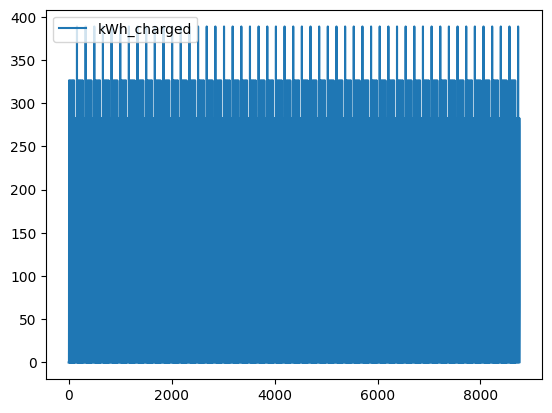

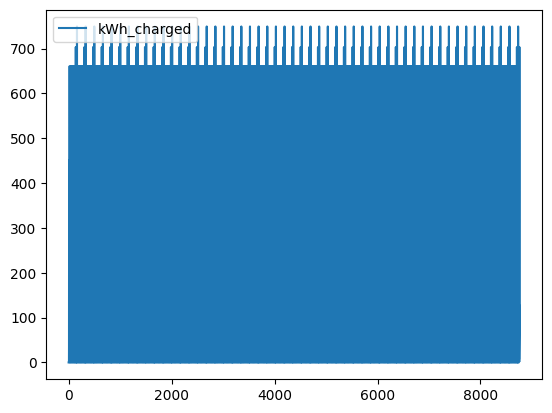

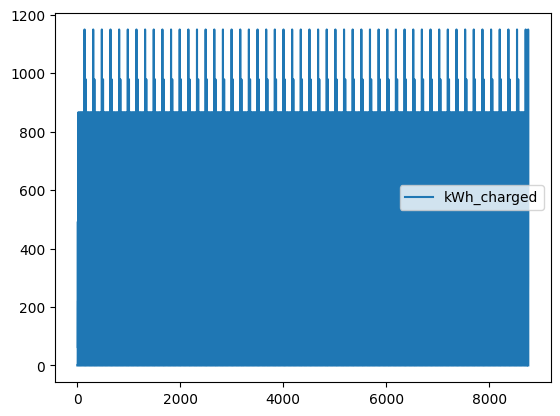

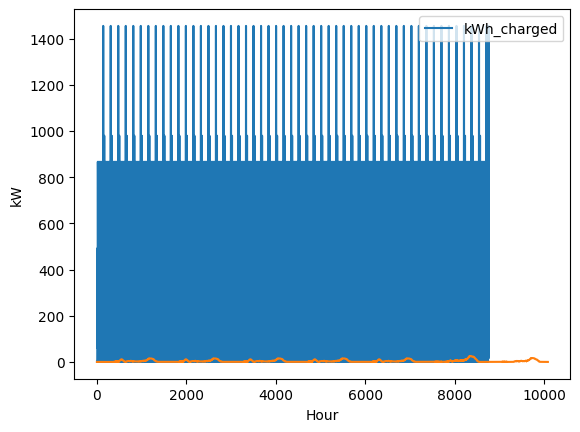

In [3]:
# Processing Weekly schedules
mon_fri_25_perc_ev = pd.concat([process_ev_schedule_data('data/3 scenarios data/ev_penetration/m-f/19,28.txt')]*5, ignore_index = True)
mon_fri_50_perc_ev = pd.concat([process_ev_schedule_data('data/3 scenarios data/ev_penetration/m-f/38,9.txt')]*5, ignore_index = True)
mon_fri_75_perc_ev = pd.concat([process_ev_schedule_data('data/3 scenarios data/ev_penetration/m-f/57,0.txt')]*5, ignore_index = True)
mon_fri_100_perc_ev = pd.concat([process_ev_schedule_data('data/3 scenarios data/ev_penetration/m-f/76,0.txt')]*5, ignore_index = True)

# Processing Saturday schedules 
sat_25_perc_ev = process_ev_schedule_data('data/3 scenarios data/ev_penetration/sat/19,38.txt')
sat_50_perc_ev = process_ev_schedule_data('data/3 scenarios data/ev_penetration/sat/38,23.txt')
sat_75_perc_ev = process_ev_schedule_data('data/3 scenarios data/ev_penetration/sat/57,10.txt')
sat_100_perc_ev = process_ev_schedule_data('data/3 scenarios data/ev_penetration/sat/76,0.txt')

# Processing Sunday schedules
sun_25_perc_ev = process_ev_schedule_data('data/3 scenarios data/ev_penetration/sun/19,21.txt')
sun_50_perc_ev = process_ev_schedule_data('data/3 scenarios data/ev_penetration/sun/38,8.txt')
sun_75_perc_ev = process_ev_schedule_data('data/3 scenarios data/ev_penetration/sun/57,0.txt')
sun_100_perc_ev = process_ev_schedule_data('data/3 scenarios data/ev_penetration/sun/76,0.txt')

# Concatenating into full weekly charging profiles
weekly_25_perc_ev = pd.concat([mon_fri_25_perc_ev, sat_25_perc_ev, sun_25_perc_ev], ignore_index = True)
weekly_50_perc_ev = pd.concat([mon_fri_50_perc_ev, sat_50_perc_ev, sun_50_perc_ev], ignore_index = True)
weekly_75_perc_ev = pd.concat([mon_fri_75_perc_ev, sat_75_perc_ev, sun_75_perc_ev], ignore_index = True)
weekly_100_perc_ev = pd.concat([mon_fri_100_perc_ev, sat_100_perc_ev, sun_100_perc_ev], ignore_index = True)

# Converting to annual charging profiles
annual_25_perc_ev = pd.concat([pd.concat([weekly_25_perc_ev] * 52, ignore_index=True), sat_25_perc_ev], ignore_index=True)
annual_50_perc_ev = pd.concat([pd.concat([weekly_50_perc_ev] * 52, ignore_index=True), sat_50_perc_ev], ignore_index=True)
annual_75_perc_ev = pd.concat([pd.concat([weekly_75_perc_ev] * 52, ignore_index=True), sat_75_perc_ev], ignore_index=True)
annual_100_perc_ev = pd.concat([pd.concat([weekly_100_perc_ev] * 52, ignore_index=True), sat_100_perc_ev], ignore_index=True)

# Downsample from minutely to hourly
annual_25_perc_ev = downsample_hourly_to_minutely(annual_25_perc_ev)
annual_50_perc_ev = downsample_hourly_to_minutely(annual_50_perc_ev)
annual_75_perc_ev = downsample_hourly_to_minutely(annual_75_perc_ev)
annual_100_perc_ev = downsample_hourly_to_minutely(annual_100_perc_ev)

plt.plot(weekly_100_perc_ev)
plt.xlabel("Hour")
plt.ylabel("kW")
plt.savefig("figures/weekly_100_perc_ev.png")
plt.show()


# write files
np.savetxt(f"processed_ev_schedule_data/annual_25_perc_ev.txt", annual_25_perc_ev)
np.savetxt(f"processed_ev_schedule_data/annual_50_perc_ev.txt", annual_50_perc_ev)
np.savetxt(f"processed_ev_schedule_data/annual_75_perc_ev.txt", annual_75_perc_ev)
np.savetxt(f"processed_ev_schedule_data/annual_100_perc_ev.txt", annual_100_perc_ev)



Mixed fleet with loadshedding (min ICE to cover)

/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_71462/3674241214.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['soc_per_min'] = np.where(df['mode'] != 'charging', 0, df['soc_per_min'])


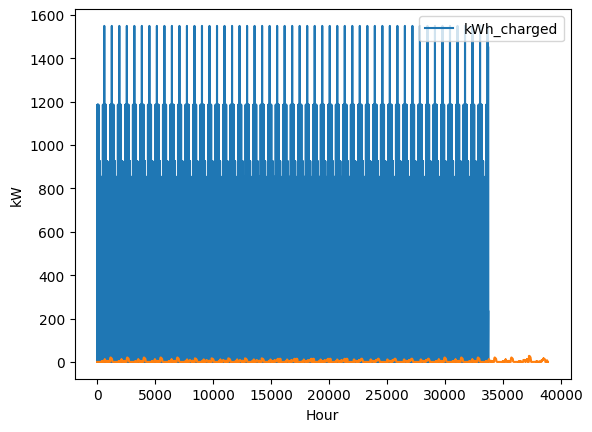

In [182]:
# Processing Weekly schedules
mon_fri_ls_1 = pd.concat([process_ev_schedule_data('data/3 scenarios data/ls_mixed_fleet/m_f_0_ev=63_ice=0_ice_distance=0.txt')]*5, ignore_index = True)
mon_fri_ls_2= pd.concat([process_ev_schedule_data('data/3 scenarios data/ls_mixed_fleet/m_f_1_ev=51_ice=0_ice_distance=0.txt')]*5, ignore_index = True)
mon_fri_ls_3 = pd.concat([process_ev_schedule_data('data/3 scenarios data/ls_mixed_fleet/m_f_2_ev=50_ice=0_ice_distance=0.txt')]*5, ignore_index = True)
mon_fri_ls_4 = pd.concat([process_ev_schedule_data('data/3 scenarios data/ls_mixed_fleet/m_f_3_ev=53_ice=0_ice_distance=0.txt')]*5, ignore_index = True)

# Processing Saturday schedules 
sat_ls_1 = process_ev_schedule_data('data/3 scenarios data/ls_mixed_fleet/sat_0_ev=73_ice=10_ice_distance=2924.5000000000064.txt')
sat_ls_2 = process_ev_schedule_data('data/3 scenarios data/ls_mixed_fleet/sat_1_ev=76_ice=1_ice_distance=307.99999999999994.txt')
sat_ls_3 = process_ev_schedule_data('data/3 scenarios data/ls_mixed_fleet/sat_2_ev=74;_ice=6_ice_distance=1744.9000000000026.txt')
sat_ls_4 = process_ev_schedule_data('data/3 scenarios data/ls_mixed_fleet/sat_3_ev=76_ice=7_ice_distance=2038.100000000004.txt')

# Processing Sunday schedules
sun_ls_1 = process_ev_schedule_data('data/3 scenarios data/ls_mixed_fleet/sun_0_ev=53_ice=0_ice_distance=0.txt')
sun_ls_2 = process_ev_schedule_data('data/3 scenarios data/ls_mixed_fleet/sun_1_ev=53_ice=0_ice_distance=0.txt')
sun_ls_3 = process_ev_schedule_data('data/3 scenarios data/ls_mixed_fleet/sun_2_ev=59_ice=0_ice_distance=0.txt')
sun_ls_4 = process_ev_schedule_data('data/3 scenarios data/ls_mixed_fleet/sun_3_ev=65_ice=0_ice_distance=0.txt')

# Concatenating into full weekly charging profiles
weekly_ls_1 = pd.concat([mon_fri_ls_1, mon_fri_ls_2, mon_fri_ls_3, mon_fri_ls_4, mon_fri_ls_1, sat_ls_2, sun_ls_3], ignore_index = True)
# weekly_ls_2 = pd.concat([mon_fri_ls_2, sat_ls_2, sun_ls_2], ignore_index = True)
# weekly_ls_3 = pd.concat([mon_fri_ls_3, sat_ls_3, sun_ls_3], ignore_index = True)
# weekly_ls_4 = pd.concat([mon_fri_ls_4, sat_ls_4, sun_ls_4], ignore_index = True)

# Converting to annual charging profiles
annual_ls_1 = pd.concat([pd.concat([weekly_ls_1] * 52, ignore_index=True), sat_ls_1], ignore_index=True)
# annual_ls_2 = pd.concat([pd.concat([weekly_ls_2] * 52, ignore_index=True), sat_ls_2], ignore_index=True)
# annual_ls_3 = pd.concat([pd.concat([weekly_ls_3] * 52, ignore_index=True), sat_ls_3], ignore_index=True)
# annual_ls_4 = pd.concat([pd.concat([weekly_ls_4] * 52, ignore_index=True), sat_ls_4], ignore_index=True)

# Downsample from minutely to hourly
annual_ls_1 = downsample_hourly_to_minutely(annual_ls_1)
# annual_ls_2 = downsample_hourly_to_minutely(annual_ls_2)
# annual_ls_3 = downsample_hourly_to_minutely(annual_ls_3)
# annual_ls_4 = downsample_hourly_to_minutely(annual_ls_4)

plt.plot(weekly_ls_1)
plt.xlabel("Hour")
plt.ylabel("kW")
plt.savefig("figures/weekly_100_perc_ev.png")
plt.show()

# write files
np.savetxt(f"processed_ev_schedule_data/annual_ls_1.txt", annual_ls_1)
# read this file back in
# np.loadtxt(f"processed_ev_schedule_data/annual_ls_1.txt")

EV only, with loadshedding and no lateness (battery sized increase) ONLY FOR SATURDAY

In [ ]:
# Processing Weekly schedules
mon_fri_ls_1 = pd.concat([process_ev_schedule_data('data/3 scenarios data/ls_only_ev_bigger_battery/m_f_0_ev=63_ice=0_ice_distance=0.txt')]*5, ignore_index = True)
mon_fri_ls_2= pd.concat([process_ev_schedule_data('data/3 scenarios data/ls_only_ev_bigger_battery/m_f_1_ev=51_ice=0_ice_distance=0.txt')]*5, ignore_index = True)
mon_fri_ls_3 = pd.concat([process_ev_schedule_data('data/3 scenarios data/ls_only_ev_bigger_battery/m_f_2_ev=50_ice=0_ice_distance=0.txt')]*5, ignore_index = True)
mon_fri_ls_4 = pd.concat([process_ev_schedule_data('data/3 scenarios data/ls_only_ev_bigger_battery/m_f_3_ev=53_ice=0_ice_distance=0.txt')]*5, ignore_index = True)

# Processing Saturday schedules 
sat_ls_1 = process_ev_schedule_data('data/3 scenarios data/ls_only_ev_bigger_battery/sat_0_ev=76_battery=100_lateness=0.txt')
sat_ls_2 = process_ev_schedule_data('data/3 scenarios data/ls_only_ev_bigger_battery/sat_1_ev=73_battery=100_lateness=0.txt')
sat_ls_3 = process_ev_schedule_data('data/3 scenarios data/ls_only_ev_bigger_battery/sat_2_ev=72_battery=120_lateness=0.txt')
sat_ls_4 = process_ev_schedule_data('data/3 scenarios data/ls_only_ev_bigger_battery/sat_3_ev=75_battery=131_lateness=0.txt')

# Processing Sunday schedules
sun_ls_1 = process_ev_schedule_data('data/3 scenarios data/ls_mixed_fleet/sun_0_ev=53_ice=0_ice_distance=0.txt')
sun_ls_2 = process_ev_schedule_data('data/3 scenarios data/ls_mixed_fleet/sun_1_ev=53_ice=0_ice_distance=0.txt')
sun_ls_3 = process_ev_schedule_data('data/3 scenarios data/ls_mixed_fleet/sun_2_ev=59_ice=0_ice_distance=0.txt')
sun_ls_4 = process_ev_schedule_data('data/3 scenarios data/ls_mixed_fleet/sun_3_ev=65_ice=0_ice_distance=0.txt')

# Concatenating into full weekly charging profiles
weekly_ls_1 = pd.concat([mon_fri_ls_1, mon_fri_ls_2, mon_fri_ls_3, mon_fri_ls_4, mon_fri_ls_1, sat_ls_2, sun_ls_3], ignore_index = True)
# weekly_ls_2 = pd.concat([mon_fri_ls_2, sat_ls_2, sun_ls_2], ignore_index = True)
# weekly_ls_3 = pd.concat([mon_fri_ls_3, sat_ls_3, sun_ls_3], ignore_index = True)
# weekly_ls_4 = pd.concat([mon_fri_ls_4, sat_ls_4, sun_ls_4], ignore_index = True)

# Converting to annual charging profiles
annual_ls_1 = pd.concat([pd.concat([weekly_ls_1] * 52, ignore_index=True), sat_ls_1], ignore_index=True)
# annual_ls_2 = pd.concat([pd.concat([weekly_ls_2] * 52, ignore_index=True), sat_ls_2], ignore_index=True)
# annual_ls_3 = pd.concat([pd.concat([weekly_ls_3] * 52, ignore_index=True), sat_ls_3], ignore_index=True)
# annual_ls_4 = pd.concat([pd.concat([weekly_ls_4] * 52, ignore_index=True), sat_ls_4], ignore_index=True)

# Downsample from minutely to hourly
annual_ls_1 = downsample_hourly_to_minutely(annual_ls_1)
# annual_ls_2 = downsample_hourly_to_minutely(annual_ls_2)
# annual_ls_3 = downsample_hourly_to_minutely(annual_ls_3)
# annual_ls_4 = downsample_hourly_to_minutely(annual_ls_4)

plt.plot(weekly_ls_1)
plt.xlabel("Hour")
plt.ylabel("kW")
plt.savefig("figures/weekly_100_perc_ev.png")
plt.show()



### <font color = 'red'> Old sample data </font>

/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_36229/3102591522.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['soc_per_min'] = np.where(df['mode'] != 'charging', 0, df['soc_per_min'])


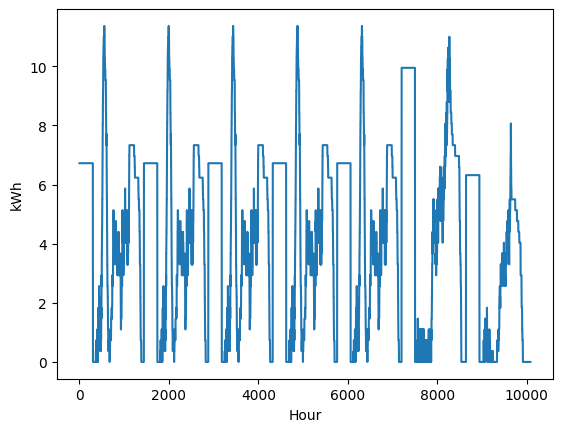

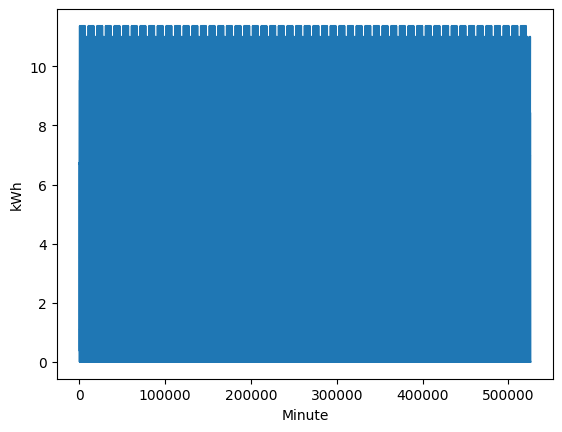

In [5]:
START_OF_OPERATIONS = 300 # 5am

# Process Monday to Friday charging profile
mon_fri_json_path = 'data/mon_to_fri_440.json'
mon_fri_title = 'Mon-Fri Charging Profile'
mon_fri_save_filename = 'mon_fri_charge_profile.png'
mon_fri_charging_profile = process_charging_profile(mon_fri_json_path, mon_fri_title, mon_fri_save_filename)

# Charging before 5am  is 0 (assume charge at home because that's where they park - or readjust when Jacques readjusts)
# stretch the charging done between 0 and 110 to be done between 0 and 300 
mon_fri_charging_profile[0:300] = mon_fri_charging_profile.iloc[0] * np.argmax(mon_fri_charging_profile == 0)/START_OF_OPERATIONS

weekly_charging_profile = pd.concat([mon_fri_charging_profile]*5, ignore_index=True)

# Process Saturday charging profile
sat_json_path = 'data/sat_686.json'
sat_title = 'Sat Charging Profile'
sat_save_filename = 'sat_charge_profile.png'
sat_charging_profile = process_charging_profile(sat_json_path, sat_title, sat_save_filename)
# stretch the charging done between 0 and 110 to be done between 0 and 300 
sat_charging_profile[0:300] = sat_charging_profile.iloc[0] * np.argmax(sat_charging_profile == 0)/START_OF_OPERATIONS

# Process Sunday charging profile
sun_json_path = 'data/sun_420.json'
sun_title = 'Sun Charging Profile'
sun_save_filename = 'sun_charge_profile.png'
sun_charging_profile = process_charging_profile(sun_json_path, sun_title, sun_save_filename)
sun_charging_profile[0:300] = sun_charging_profile.iloc[0] * np.argmax(sun_charging_profile == 0)/START_OF_OPERATIONS

# Get a full week charging profile 
charging_profile = pd.concat([weekly_charging_profile, sat_charging_profile, sun_charging_profile], ignore_index = True)
# Downsample to hourly resolution 
plt.plot(charging_profile)
plt.xlabel("Hour")
plt.ylabel("kWh")
plt.savefig("figures/charging_profile.png")
plt.show()

# Get a yearly version of the charging profile
charging_profile_year = pd.concat([charging_profile]*52, ignore_index=True)
charging_profile_year = pd.concat([charging_profile_year, sat_charging_profile], ignore_index=True) #add another day to reach 365 days (52 weeks + 1 day)
plt.plot(charging_profile_year)
plt.xlabel("Minute")
plt.ylabel('kWh')
plt.show()



Downsample from minutely to hourly

This must be 8760:  8760


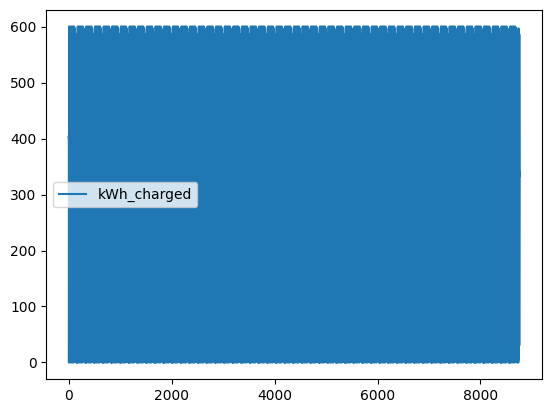

In [190]:
# Select every 60th row using array indexing
hourly_charging_profile = charging_profile_year.rolling(window=60).sum().iloc[::60]

# Reset the index to RangeIndex if desired
hourly_charging_profile.reset_index(drop=True, inplace=True)

hourly_charging_profile.plot()
load_profile_optimized = hourly_charging_profile['kWh_charged'].values
# fill NaN values with 0
load_profile_optimized = np.nan_to_num(load_profile_optimized)
print("This must be 8760: ", len(load_profile_optimized))

### Solar profile

Renewables.ninja

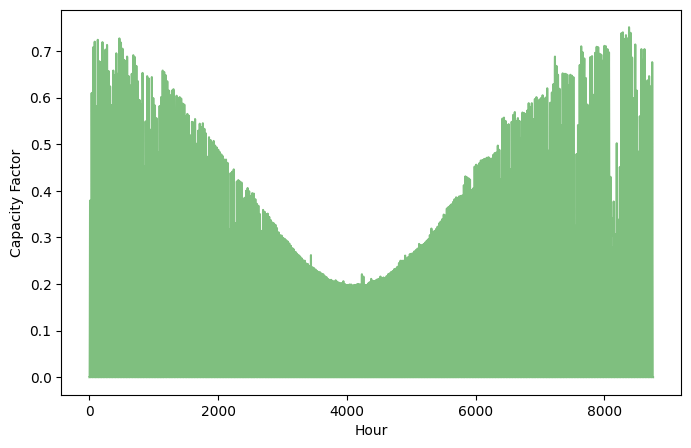

In [20]:
# Read starting from line 4
annual_capacity_factor = pd.read_csv("solar_profiles/renewables_ninja_profile.csv", skiprows=3)
annual_capacity_factor = annual_capacity_factor['electricity'].values
plt.plot(annual_capacity_factor, color = 'green', alpha = 0.5)
plt.ylabel('Capacity Factor')
plt.xlabel('Hour')
# Make graph wider
plt.gcf().set_size_inches(8, 5)

plt.savefig('solar_profiles/renewables_ninja_profile.png')
plt.show()


### Define input parameters

In [7]:
rand_to_usd = 1/16

Solar PV 

In [8]:
# Solar PV cost
panel_wattage = 415 # Rand
cost_per_panel = 2633.35 # Rand
cost_per_watt = cost_per_panel / panel_wattage
cost_per_watt_usd = cost_per_watt * rand_to_usd
pv_cost_per_kw = cost_per_watt_usd * 1000 # $/kW

# Inverter 
inverter_cost = 1000 * rand_to_usd # USD / kW 
# inverter_cost = inverter_cost * rand_to_usd # $/kW 

# inverter_cost_schedule = {2000: 7635.66,
#                           5000: 13957.40,
#                           8000: 18000.00, 
#                           25000: 39695.29,
#                           80000: 63184.85}

# convert all values in inverter cost schedule to usd
# inverter_cost_schedule = {key: value * rand_to_usd for key, value in inverter_cost_schedule.items()}


# Components cost
component_cost = inverter_cost + pv_cost_per_kw # $/kW

# Other costs
peripherals_cost = component_cost * 0.20 # $/kW
installation_cost = (component_cost + peripherals_cost) * 0.10 # $/kW
markup_cost = (component_cost + peripherals_cost + installation_cost) * 0.33 # $/kW

# Total capital cost
total_cost = component_cost + peripherals_cost + installation_cost + markup_cost # $/kW

# Maintenance cost 
pv_annual_maintenance_cost = 200 * rand_to_usd # $/kW

# PV system specifications
pv_efficiency = 0.90  # 85% efficiency
pv_m_sq_per_kw = 2/0.465 # m^2/kW
Rproj = 25 # project lifetime (yrs)
solar_annual_degradation = 0.006 # 0.6% degradation per year

# Residual value
solar_residual_value_factor = 0.10 # %

Battery

In [9]:
# Battery cost
battery_size = 2400 #Wh
cost_per_battery = 12308.12 # Rand
battery_cost_per_wh = cost_per_battery/battery_size
# convert to usd
battery_cost_per_kwh = battery_cost_per_wh * rand_to_usd * 1000  # $/kWh 

battery_annual_maintenance = 200 * rand_to_usd # $/kW

# Battery system specifications
battery_charging_efficiency = 0.99 #%
battery_discharging_efficiency = 0.99 #% 
battery_annual_degradation = 0.005 # % per year
battery_duration = 2 # hours (for max power draw
battery_depth_of_discharge = 0.90 # %

# lifetime ratings
battery_energy_throughput = 2e5 #kWh - total energy battery can output in lifetime
battery_max_cycles = 6000 # num cycles battery can run through in lifetime
battery_end_of_life_perc = 0.80 # percent of original capacity left at end of life 

# Residual value
battery_residual_value_factor = 0.1 # % of initial cost

# Trickle charge
battery_trickle_charging_rate = 2.2 # kWh
enable_trickle_charging = True


Inverter
(assuming 20% of PV cost for now)

In [10]:
inverter_cost_per_kw = 0.20 * pv_cost_per_kw 
inverter_cost_per_kw

79.31777108433735

Grid energy costs and schedule

In [11]:
# Energy costs and schedule 

time_of_use_tariffs_high = {'peak': 6.97 * rand_to_usd, 'standard': 2.46 * rand_to_usd, 'off_peak': 1.57 * rand_to_usd} 
time_of_use_tariffs_low = {'peak': 2.61 * rand_to_usd, 'standard': 1.95 * rand_to_usd, 'off_peak': 1.42 * rand_to_usd}
high_period_start = 24 * (31 + 28 + 31 + 30 + 31) # 1st hour of June
high_period_end = high_period_start + 24 * (30 + 31 + 31) # 1st hour of November

time_periods = {'peak_hours': [7,8,9,18,19],
                'standard_hours': [6,10,11,12,13,14,15,16,17,20,21],
                'off_peak_hours': [0,1,2,3,4,5,23]}



# Energy market inputs
feed_in_tariff = 0.041 # $/kWh

Economic inputs 

In [12]:

# Financial market inputs
i_no = 0.15 # nominal interest rate
inflation_rate = 0.0704 # inflation rate
discount_rate = 0.05 # discount rate

# Financing terms
loan_upfront_adjustment = 0.00 # % of capital cost paid upfront
loan_payback_period = 20 # 10 years for the solar PV system provider to fully recoup their costs
loan_interest_rate = 0.05

pays_capital_adjustment = 0.30 # 30% of capital cost paid upfront
pays_payback_period = 20 # 10 years for the solar PV system provider to fully recoup their costs
pays_interest_rate = 0.05 # 5% annual interest rate
pays_cut_of_savings = 0.50 # 50% of savings go to the solar PV system provider


Environmental parameters

In [13]:
# Environmental inputs
grid_carbon_intensity = 0.95 # kgCO2/kWh
carbon_price = 50/1000 # $/kgCo2

Operational ICE inputs

In [14]:
# Taxi market inputs
cost_per_passenger = 0.50 # $/passenger

# Values of kWh in terms of passengers for different time periods 
time_passenger_per_kWh = {'morning': 0.25, 
                          'afternoon': 0.125,
                          'evening': 0.25, 
                          'night': 0.05}

# ICE vehicle specs
kwh_km = 0.70 # kWh/km
L_km = 0.15
km_L = 1/L_km# km/L
kwh_L = kwh_km * km_L # kWh/L

cost_diesel = 1.05 # $/L



In [104]:


# Station constraints
max_land_area = 300 # m^2

# System specifications
loadshedding_probability = 3776 / 8760


##### LOAD PROFILE
# load_profile = WB_yearly_data
#load_profile = load_profile_simulated
#load_profile = load_profile_optimized
# load_profile = load_profile_brendan

#### ICE VEHICLE USAGE ESTIMATES
#vehicle_kWh_km = 0.20 # kWh/km
#vehicle_km_per_year = vehicle_kWh_km * sum(load_profile)

a = {
    # Solar PV Profile 
    'annual_capacity_factor': annual_capacity_factor,
    # EV charging load 
    'load_profile': annual_25_perc_ev,
    # PV costs 
    'pv_cost_per_kw': pv_cost_per_kw,
    'pv_annual_maintenance_cost': pv_annual_maintenance_cost,
    'solar_residual_value_factor': solar_residual_value_factor,
    # Inverter costs
    'inverter_cost_per_kw': inverter_cost_per_kw, 
    'linearize_inverter_cost': True, 
    # PV specifications
    'Rproj': Rproj,
    'pv_efficiency': pv_efficiency,
    'solar_annual_degradation': solar_annual_degradation,# 0.6% per year
    # Battery costs
    'battery_cost_per_kWh': battery_cost_per_kwh,
    'battery_annual_maintenance_cost': battery_annual_maintenance,
    'battery_residual_value_factor': battery_residual_value_factor,
    'depth_of_discharge': battery_depth_of_discharge,
    # Battery specs
    'battery_charging_efficiency': battery_charging_efficiency,
    'battery_discharging_efficiency': battery_discharging_efficiency,
    'battery_annual_degradation': battery_annual_degradation, # 2% per year
    'battery_duration': battery_duration, 
    'battery_max_cycles': battery_max_cycles,
    'battery_max_energy_throughput': battery_energy_throughput,
    'battery_end_of_life_perc': battery_end_of_life_perc,
    'battery_trickle_charging_rate': battery_trickle_charging_rate,
    'enable_trickle_charging': True,
    'repurchase_battery': True,
    # Energy costs and schedule 
    'time_of_use_tariffs_high': time_of_use_tariffs_high,
    'time_of_use_tariffs_low': time_of_use_tariffs_low,
    'high_period_start': high_period_start,
    'high_period_end': high_period_end,
    'time_periods': time_periods,
    'feed_in_tariff': feed_in_tariff,
    # Market inputs 
    'i_no': i_no,
    'f': inflation_rate,
    'discount_rate': discount_rate,
    'cost_diesel': cost_diesel,
    # Vehicle specs
    'L_km': L_km, 
    'kwh_km': kwh_km,
    # Environmental inputs 
    'grid_carbon_intensity': grid_carbon_intensity,
    'carbon_price': carbon_price,
    # Load shedding and operational cost of serving demand during load shedding  
    'loadshedding_probability': loadshedding_probability,
    'time_passenger_per_kWh': time_passenger_per_kWh,
    'cost_per_passenger': cost_per_passenger,
    # Loan model
    'loan_upfront_adjustment': loan_upfront_adjustment,
    'loan_payback_period': loan_payback_period,
    'loan_interest_rate': loan_interest_rate,
    # PAYS model
    'PAYS_capital_cost_adjustment': pays_capital_adjustment,
    'PAYS_payback_period': pays_payback_period,
    'PAYS_cut_of_savings': pays_cut_of_savings,
    'PAYS_interest_rate': pays_interest_rate,
    # Sensitivity analysis bools
    'feed_in_tariff_bool': False,
    'renewables_ninja': True,
    'carbon_price_bool': False,
    'load_shedding_bool': False,
    # Land area 
    'pv_m_sq_per_kw': pv_m_sq_per_kw,
    'max_land_area' : max_land_area,
    
    # Battery cell specs
    'V_nom': 3.7,
    'V_max': 4.15, 
    'R': 148, 
    'Q_nom': 2.2,
    'E_nom': 2.2 * 3.7,
    'a_v': 67.92,
    'b_v': 3.592
}

## Optimization Model

### <font color = 'orange'> Base level optimization [this works don't touch it for now] (DEPRECATED USE DEGRADATION AS BASE ONE) <font>

In [87]:
reload(generate_data)
reload(economic_analysis)
reload(optimization)

# Constrain PV and Battery Capacities to be between 1 and 100 kW and kWh respectively
bounds = [(0.1,1000), (0.1,1000)]

initial_guess = [20, 20]

a['load_profile'] = load_profile * 0.10

# Max land area constraint 
constraint = {'type': 'ineq', 'fun': lambda x: a['max_land_area'] - (x[0] * a['pv_m_sq_per_kw'])} # ineq assumes >= 0

# Optimize
result = minimize(optimization.objective_function, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV power rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery energy capacity: {:.2f} kWh".format(optimal_battery_capacity))
print("Investment cost: ${:.2f}".format((a['battery_cost_per_kWh'] * optimal_battery_capacity) + economic_analysis.calculate_pv_capital_cost(optimal_pv_capacity, a)))
print("Net present value (NPV): ${:.2f}".format(-max_npv))


Optimal PV power rating: 55.57 kW
Optimal battery energy capacity: 18.65 kWh
Investment cost: $43704.64
Net present value (NPV): $40305.54


### <font color = 'lightgreen'> Optimization solar and battery degradation (no financing) - BASE CASE </font>

In [25]:
reload(generate_data)
reload(economic_analysis)
reload(optimization)

# Constrain PV and Battery Capacities to be between 1 and 100 kW and kWh respectively
bounds = [(0.1,1000), (0.1,1000)]

initial_guess = [200, 200]

# Max land area constraint 
constraint = {'type': 'ineq', 'fun': lambda x: a['max_land_area'] - (x[0] * a['pv_m_sq_per_kw'])} # ineq assumes >= 0

# Optimize
result = minimize(optimization.objective_function_with_solar_and_battery_degradation, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV power rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery energy capacity: {:.2f} kWh".format(optimal_battery_capacity))
print("Investment cost: ${:.2f}".format((a['battery_cost_per_kWh'] * optimal_battery_capacity) + economic_analysis.calculate_capital_cost(optimal_pv_capacity, optimal_battery_capacity, a)))
print("Net present value (NPV): ${:.2f}".format(-max_npv))

Optimizing:   0%|                                                                             | 0/25

KeyError: 'annual_insolation_profile'

### <font color = 'lightgreen'> Solar and battery degradation and loan </font>

In [173]:
reload(generate_data)
reload(economic_analysis)
reload(optimization)

# Constrain PV and Battery Capacities to be between 1 and 100 kW and kWh respectively
bounds = [(1,1000), (1,1000)]
initial_guess = [200, 200]

# Optimize
result = minimize(optimization.objective_function_with_solar_and_battery_degradation_loan, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Maximum NPV: ${:.2f}".format(-max_npv))


Optimizing: 100%|████████████████████████████████████████████████████████████████████████████| 25/25
Optimizing: 100%|████████████████████████████████████████████████████████████████████████████| 25/25
Optimizing: 100%|████████████████████████████████████████████████████████████████████████████| 25/25
Optimizing: 100%|████████████████████████████████████████████████████████████████████████████| 25/25
Optimizing: 100%|████████████████████████████████████████████████████████████████████████████| 25/25
Optimizing: 100%|████████████████████████████████████████████████████████████████████████████| 25/25
Optimizing: 100%|████████████████████████████████████████████████████████████████████████████| 25/25
Optimizing: 100%|████████████████████████████████████████████████████████████████████████████| 25/25
Optimizing: 100%|████████████████████████████████████████████████████████████████████████████| 25/25
Optimizing: 100%|██████████████████████████████████████████████████████████████████████████

Optimal PV rating: 200.67 kW
Optimal battery rating: 198.79 kWh
Maximum NPV: $50848.47


Gathering info about optimal system

In [37]:
battery_capacity = 60
pv_capacity = optimal_pv_capacity
battery_energy_throughput = 0
battery_max_energy_throughput = generate_data.get_battery_max_energy_throughput(battery_capacity, a)


# For storing stats
trickle_costs =[]
net_load_profiles =[]
battery_energy_profiles =[]

for year in range(a['Rproj']):
        
    usable_pv_capacity = pv_capacity * (1 - a['solar_annual_degradation'])**year # degrade PV and battery by respective degradation rates
    # usable_battery_capacity = battery_capacity * (1 - a['battery_annual_degradation'])**year
    
    usable_battery_capacity = battery_capacity - (battery_capacity * (battery_energy_throughput / battery_max_energy_throughput) * (1 - a['battery_end_of_life_perc']))

    # Generate PV Output profile 
    pv_output_profile = generate_data.get_pv_output(a['annual_capacity_factor'], usable_pv_capacity) 
            
    if battery_energy_throughput <= battery_max_energy_throughput: 
            # degrade battery capacity by battery degradation rate
            pv_with_battery_output_profile, battery_throughput, cost_of_trickle_charging = generate_data.simulate_battery_storage_v5(pv_output_profile, usable_battery_capacity, battery_energy_throughput, battery_max_energy_throughput, a)
            print('current throughput:', battery_energy_throughput, 'gained', (battery_throughput - battery_energy_throughput), 'update to:', battery_throughput)
            battery_energy_throughput = battery_throughput # update battery cycles left
            
            
    else:
        print('battery dead')
        if a['repurchase_battery']: 
            print('battery repurchsed')
            battery_repurchase_cost = a['battery_cost_per_kWh'] * battery_capacity
            usable_battery_capacity = battery_capacity
            battery_energy_throughput = 0
            pv_with_battery_output_profile,battery_throughput, cost_of_trickle_charging = generate_data.simulate_battery_storage_v4(pv_output_profile, battery_capacity, battery_energy_throughput,  battery_max_energy_throughput,  a)
            print('current throughput:', battery_energy_throughput, 'gained', (battery_throughput - battery_energy_throughput), 'update to:', battery_throughput)
            battery_energy_throughput = battery_throughput
            
        else:
            print('no more battery')
            pv_with_battery_output_profile = pv_output_profile 
            
    trickle_costs.append(cost_of_trickle_charging)
    
    battery_energy_profile = pv_with_battery_output_profile - pv_output_profile
    net_load_profile = a['load_profile'] - pv_with_battery_output_profile
    
    battery_energy_profiles.append(battery_energy_profile)
    
    net_load_profiles.append(net_load_profile)
            
        

current throughput: 0 gained 0.0 update to: 0.0
current throughput: 0.0 gained 0.0 update to: 0.0
current throughput: 0.0 gained 0.0 update to: 0.0
current throughput: 0.0 gained 0.0 update to: 0.0
current throughput: 0.0 gained 0.0 update to: 0.0
current throughput: 0.0 gained 0.0 update to: 0.0
current throughput: 0.0 gained 0.0 update to: 0.0
current throughput: 0.0 gained 0.0 update to: 0.0
current throughput: 0.0 gained 0.0 update to: 0.0
current throughput: 0.0 gained 0.0 update to: 0.0
current throughput: 0.0 gained 0.0 update to: 0.0
current throughput: 0.0 gained 0.0 update to: 0.0
current throughput: 0.0 gained 0.0 update to: 0.0
current throughput: 0.0 gained 0.0 update to: 0.0
current throughput: 0.0 gained 0.0 update to: 0.0
current throughput: 0.0 gained 0.0 update to: 0.0
current throughput: 0.0 gained 0.0 update to: 0.0
current throughput: 0.0 gained 0.0 update to: 0.0
current throughput: 0.0 gained 0.0 update to: 0.0
current throughput: 0.0 gained 0.0 update to: 0.0
cu

Debugging battery charging model   

In [55]:
battery_capacity = 100
pv_capacity = 100
battery_energy_throughput = 0
battery_max_energy_throughput = generate_data.get_battery_max_energy_throughput(battery_capacity, a)


# For storing stats
trickle_costs =[]
net_load_profiles =[]
battery_energy_profiles =[]


# Generate PV Output profile 
pv_output_profile = generate_data.get_pv_output(a['annual_capacity_factor'], usable_pv_capacity) 
        
if battery_energy_throughput <= battery_max_energy_throughput: 
        # degrade battery capacity by battery degradation rate
        pv_with_battery_output_profile, battery_throughput, cost_of_trickle_charging = generate_data.simulate_battery_storage_v5(pv_output_profile, usable_battery_capacity, battery_energy_throughput, battery_max_energy_throughput, a)
        print('current throughput:', battery_energy_throughput, 'gained', (battery_throughput - battery_energy_throughput), 'update to:', battery_throughput)
        battery_energy_throughput = battery_throughput # update battery cycles left

current throughput: 0 gained -263888769.38095438 update to: -263888769.38095438


In [157]:

soc = 0.90
battery_capacity = 100

net_load = 11.04 # kWh 

charge_eff = 0.88
V_t = a['V_max'] - a['Q_nom'] * (a['R']/1e3)

M_p = np.sqrt(battery_capacity*1e3 / (2 * a['E_nom']))
M_s = 2 * M_p 

# Pre-compute battery cell characteristics
R_equiv = ((a['R']/1e3) * M_s) / M_p

# a['E_nom'] = a['V_nom'] * a['Q_nom'] # W

# Use SOC to find open circuit voltage
V_oc = (a['a_v']/1e3) * (soc * a['E_nom']) + a['b_v']

# Find equivalent open circuit voltage (equivalent = for whole battery)
V_oc_equiv = V_oc * M_s    

# Find battery voltage
V_b = V_oc/2 + np.sqrt(charge_eff * net_load * R_equiv + (V_oc**2)/4)

# Find battery current
I_b = (M_s * a['V_max'] - V_oc_equiv) / R_equiv

# Find power draw
P_stored = (M_s * a['V_max'] * I_b) / charge_eff /1e3  # kW



V_terminal = V_b / M_s

print("V_terminal:", V_terminal, "\n",
"V open circuit:", V_oc, "\n",
"V_oc_equivalent:", V_oc_equiv, "\n",
"Battery current:", I_b, "\n",
"Power stored:", P_stored, 'kW')

    
  

V_terminal: 0.02999246747578326 
 V open circuit: 4.0895819200000005 
 V_oc_equivalent: 641.0349486689548 
 Battery current: 31.994697192398714 
 Power stored: 23.650821164027633 kW


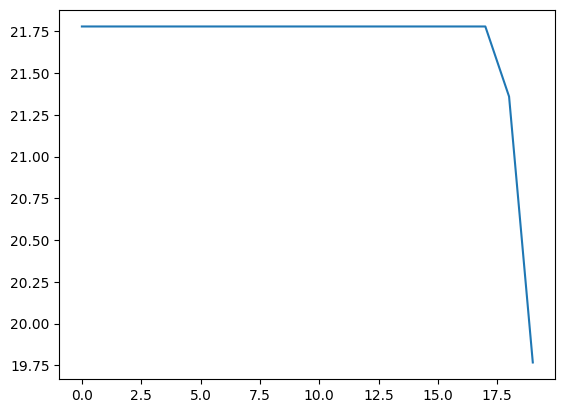

In [165]:
effs = []
charge = []
for state_of_charge in np.arange(0,100, 5):
    if state_of_charge <= 85 :
        curr_charge_efficiency = a['battery_charging_efficiency']
    else:
        #curr_charge_efficiency = a['battery_charging_efficiency'] * battery_current_energy
        curr_charge_efficiency = (1 - math.exp((state_of_charge-85)/4)/120) #TODO: Chat with Brendan to get the actual equation
        
    effs.append(curr_charge_efficiency)
    charge.append(curr_charge_efficiency * 22)
    
#plt.plot(effs)
plt.plot(charge)

V_terminal: 0.04628018822230531 
 V open circuit: 4.0066516000000005 
 V_oc_equivalent: 400.66516000000007 
 Battery current: 48.428513513513465 
 Power stored: 22.838446713759193 kW
V_terminal: 0.04632893689348214 
 V open circuit: 4.012180288000001 
 V_oc_equivalent: 401.21802880000007 
 Battery current: 46.56071351351347 
 Power stored: 21.957609213759195 kW
V_terminal: 0.04637769768863524 
 V open circuit: 4.017708976 
 V_oc_equivalent: 401.77089759999996 
 Battery current: 44.69291351351386 
 Power stored: 21.076771713759378 kW
V_terminal: 0.04642647057857154 
 V open circuit: 4.023237664 
 V_oc_equivalent: 402.32376639999995 
 Battery current: 42.82511351351386 
 Power stored: 20.195934213759383 kW
V_terminal: 0.046475255534174933 
 V open circuit: 4.028766352 
 V_oc_equivalent: 402.8766352 
 Battery current: 40.957313513513675 
 Power stored: 19.315096713759292 kW
V_terminal: 0.046524052526406144 
 V open circuit: 4.03429504 
 V_oc_equivalent: 403.429504 
 Battery current: 39.08

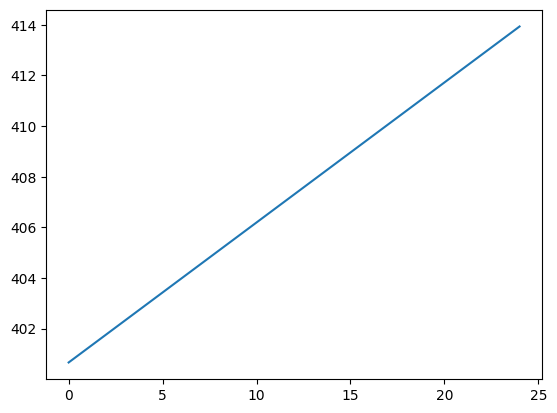

In [148]:
currents = []
voltages = []
power_draws = []
soc_list = np.arange(0.75, 1.0, 0.01)
for soc in soc_list:
    battery_capacity = 40.7

    net_load = 11.04 # kWh 

    charge_eff = 0.88


    M_p = np.sqrt(battery_capacity*1e3 / (2 * a['E_nom']))
    M_s = 2 * M_p 

    # Pre-compute battery cell characteristics
    R_equiv = ((a['R']/1e3) * M_s) / M_p

    # a['E_nom'] = a['V_nom'] * a['Q_nom'] # W

    # Use SOC to find open circuit voltage
    V_oc = (a['a_v']/1e3) * (soc * a['E_nom'] + 60*) + a['b_v']

    # Find equivalent open circuit voltage (equivalent = for whole battery)
    V_oc_equiv = V_oc * M_s    

    # Find battery voltage
    V_b = V_oc/2 + np.sqrt(charge_eff * net_load * R_equiv + (V_oc**2)/4)

    # Find battery current
    I_b = (M_s * a['V_max'] - V_oc_equiv) / R_equiv

    # Find power draw
    P_stored = (M_s * a['V_max'] * I_b) / charge_eff /1e3  # kW



    V_terminal = V_b / M_s
    
    currents.append(I_b)
    power_draws.append(P_stored)
    voltages.append(V_oc_equiv)
    print("V_terminal:", V_terminal, "\n",
    "V open circuit:", V_oc, "\n",
    "V_oc_equivalent:", V_oc_equiv, "\n",
    "Battery current:", I_b, "\n",
    "Power stored:", P_stored, 'kW')

plt.plot(voltages)
    
    
  

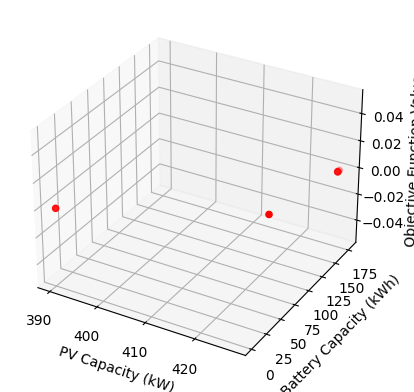

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Initialize lists to store data from the file
pv_capacities = []
battery_capacities = []

# Read data from the file "solutions.txt"
with open("solutions.txt", "r") as file:
    for line in file:
        values = line.strip().split("\t")
        pv_capacity = float(values[0])
        battery_capacity = float(values[1])
        pv_capacities.append(pv_capacity)
        battery_capacities.append(battery_capacity)

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pv_capacities, battery_capacities, c='r', marker='o')

ax.set_xlabel('PV Capacity (kW)')
ax.set_ylabel('Battery Capacity (kWh)')
ax.set_zlabel('Objective Function Value')

plt.show()



In [7]:
pv_capacities, battery_capacities

([423.670127,
  390.128691,
  427.295039,
  427.295039,
  427.295039,
  427.295039,
  427.295039,
  427.295039],
 [82.186412,
  2.74365,
  174.279709,
  174.279709,
  174.279709,
  174.279709,
  174.279709,
  177.202433])

In [84]:
M_p, M_s, battery_capacity *1e3, 370 * 110

(1.0, 5000, 40700.0, 40700)

Plotting the PV and battery output (for results!) <font color = 'orange'> Plot time of use tariffs on second axis </font>

In [495]:
a['time_of_use_tariffs_high']

{'peak': 0.435625, 'standard': 0.15375, 'off_peak': 0.098125}

In [506]:

def get_weekly_tariff_schedule(tou_tariffs, time_periods):
    # initialize one array for weekdays
    time = np.zeros(24)
    week_tariffs = np.zeros(24)
    for idx, t in enumerate(time): 
        if idx in time_periods['peak_hours']:
            week_tariffs[idx] = tou_tariffs['peak']
        elif idx in time_periods['standard_hours']:
            week_tariffs[idx] = tou_tariffs['standard']
        else:
            week_tariffs[idx] = tou_tariffs['off_peak']
    
    # repeat tariffs five times 
    week_tariffs = np.tile(week_tariffs,5)
    
    weekend_tariffs=np.empty(48)
    weekend_tariffs.fill(tou_tariffs['off_peak'])

    
    
    # add week and weekend tariffs together
    tariff_schedule = np.append(week_tariffs, weekend_tariffs)

    
    
    return tariff_schedule
    
    
    
    

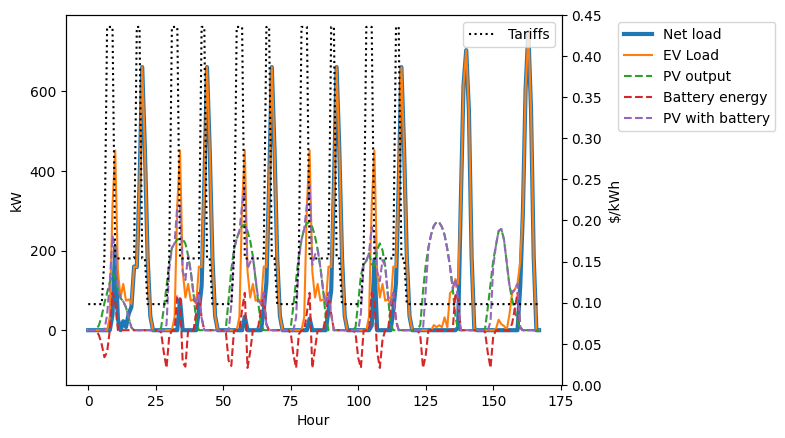

In [534]:
fig, ax = plt.subplots()
ax.plot(nlp[0:(24*7)], linewidth = 3, label = 'Net load')
ax.plot(a['load_profile'][0:(24*7)], label = 'EV Load')
ax.plot(pv_output_profile[0:(24*7)], linestyle = 'dashed', label = 'PV output')
ax.plot(battery_energy_profile[0:(24*7)], linestyle = 'dashed', label = 'Battery energy')
ax.plot(pv_with_battery_output_profile[0:(24*7)], linestyle = 'dashed', label = 'PV with battery')
ax.legend(bbox_to_anchor = (1.1,1))
ax.set_ylabel("kW")
# start a dual axis and plot the time of use tariffs
ax2 = ax.twinx()
ax2.plot(get_weekly_tariff_schedule(a['time_of_use_tariffs_high'], a['time_periods']), label = 'Tariffs', color = 'black', linestyle = 'dotted')
ax2.set_ylim(0, 0.45)
ax2.set_ylabel("$/kWh")
ax2.legend()
ax.set_xlabel("Hour")
plt.show()


In [ ]:
# Look at the net laod profile



### <font color = 'red'> Solar and battery degradation and PAYS  (ignore) </font>

In [339]:
reload(generate_data)
reload(economic_analysis)
reload(optimization)

# Constrain PV and Battery Capacities to be between 1 and 100 kW and kWh respectively
bounds = [(1,1000), (1,1000)]
initial_guess = [20, 20]

# Optimize
result = minimize(optimization.objective_function_with_solar_and_battery_degradation_PAYS, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Maximum NPV: ${:.2f}".format(-max_npv))

# Constraint value
# constraint_value = constraint['fun'](result.x, a)
# print("Constraint value: {:.2f}".format(constraint_value))

Optimal PV rating: 1.00 kW
Optimal battery rating: 1.00 kWh
Maximum NPV: $-2164.73


## <font color = 'lightgreen'> LCOE, Net present cost, and P_grid </font>

Compute average grid price ($/kWh) faced by vehicles (aka P_grid)


In [305]:
annual_100_perc_ev

8760

In [308]:
cost = 0
for hour, kwh in enumerate(annual_100_perc_ev):
    
    # In winter
    if hour > a['high_period_start'] and hour <= a['high_period_end']:
        off_peak = time_of_use_tariffs_high['off_peak']
        standard = time_of_use_tariffs_high['standard']
        peak = time_of_use_tariffs_high['peak']
    else:
        off_peak = time_of_use_tariffs_low['off_peak']
        standard = time_of_use_tariffs_low['standard']
        peak = time_of_use_tariffs_low['peak']
        
    
    if (hour % 168) > 120: # weekend
        cost += kwh * off_peak
        
    elif (hour % 24) in time_periods['peak_hours']:
        cost += kwh * peak
        
    elif (hour % 24) in time_periods['standard_hours']:
        cost += kwh * standard
        
    else:
        cost += kwh * off_peak
        
p_grid = cost/annual_100_perc_ev.sum()
print("Average grid electricity price:", p_grid)

Average grid electricity price: 0.12791866993178577


### <font color  = 'lightgreen'> Getting detailed results for Results section in paper </font>

Energy served by PV over project lifetime


In [299]:
def get_energy_served_by_pv(optimal_pv_capacity, a):
    
    total_energy_served_by_pv = 0 
    
    for year in range(a['Rproj']):
        # Generate PV Output profile 
        optimal_pv_capacity = optimal_pv_capacity * (1 - a['solar_annual_degradation'] * year) # degrade PV capacity by solar degradation rate
        pv_output_profile = generate_data.get_pv_output(a['annual_capacity_factor'], a['annual_insolation_profile'], a['pv_efficiency'], a['renewables_ninja'], optimal_pv_capacity)
        
        
        energy_served_by_pv = a['load_profile'] - (a['load_profile'] - pv_output_profile)
        total_energy_served_by_pv += energy_served_by_pv.sum()
        
    return total_energy_served_by_pv
get_energy_served_by_pv(optimal_pv_capacity, a)

1307390.589500301

Financial results with loan

In [258]:
# Decision variables - PV capacity and Battery capacity 
pv_capacity = optimal_pv_capacity
battery_capacity = optimal_battery_capacity 

# Capital Cost of Investment 
pv_capital_cost = economic_analysis.calculate_pv_capital_cost(pv_capacity,a, linearize = a['linearize_inverter_cost'])
battery_capital_cost = a['battery_cost_per_kWh'] * battery_capacity  # (int) capital cost of battery
total_capital_cost = pv_capital_cost + battery_capital_cost

# Residual value
pv_residual_value = a['solar_residual_value_factor'] * pv_capital_cost
battery_residual_value = a['battery_residual_value_factor'] * battery_capital_cost


# Maintenance costs 
maintenance_costs = (a['pv_annual_maintenance_cost'] * pv_capacity) + (a['battery_annual_maintenance_cost'] * battery_capacity)

#### Loan Business Model ####
upfront_payment = a['loan_upfront_adjustment'] * total_capital_cost # (int) upfront payment for panels
residual_cost_of_panels_owed = (total_capital_cost - upfront_payment) * (1 + a['loan_interest_rate']) # (int) residual cost of panels owed with interest


# to hold annual revenue streams that will then be discounted according to when they occur in the final NPV calculation
revenues = []


for year in range(a['Rproj']):
    pv_capacity = pv_capacity * (1 - a['solar_annual_degradation'] * year) # degrade PV capacity by solar degradation rate
    
    # Generate PV Output profile 
    pv_output_profile = generate_data.get_pv_output(a['annual_capacity_factor'], a['annual_insolation_profile'], a['pv_efficiency'], a['renewables_ninja'], pv_capacity) 
    
    battery_capacity = battery_capacity * (1 - a['battery_annual_degradation'] * year)
    # degrade battery capacity by battery degradation rate
    pv_with_battery_output_profile = generate_data.simulate_battery_storage(a['load_profile'], pv_output_profile, battery_capacity, a['battery_duration'],
                                                                        a['battery_charging_efficiency'], a['battery_discharging_efficiency'],
                                                                        a['depth_of_discharge'])
    
        
        
    # Generate load shedding schedule 
    loadshedding_schedule = generate_data.generate_loadshedding_schedule(pv_output_profile, a['loadshedding_probability'])
    
    # Net charging load profile 
    net_load_profile = a['load_profile'] - pv_with_battery_output_profile
    
    

    # Profile of kWh that would be lost to load shedding WITHOUT  solar and battery 
    gross_load_affected_by_loadshedding = np.array([a['load_profile'][i] if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)])
    
    # Profile of kWh that would have been lost to loadshedding but are saved by the solar + battery generation [these are beneficial, and not to be charged $$ for]
    saved_free_kWh = [min(pv_with_battery_output_profile[i], gross_load_affected_by_loadshedding[i]) if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)]
    
    # Profile of kWh that would be lost to load shedding WITH solar and battery
    net_load_affected_by_loadshedding = np.array([net_load_profile[i] if is_shedding and net_load_profile[i] > 0 else 0 for i, is_shedding in enumerate(loadshedding_schedule)])
    
    # Find the load profiles that are net of load shedding - this is the load you neeed to charge $ for [in reality you will need an entirely new schedule] 
    gross_load_minus_loadshedding = a['load_profile'] - gross_load_affected_by_loadshedding
    net_load_minus_loadshedding = net_load_profile - net_load_affected_by_loadshedding 
    
    if a['load_shedding_bool']:
            # Value of kWh saved from loadshedding BY solar + battery!  [makes above not needed?]
        value_of_charging_saved_by_pv_from_loadshedding = economic_analysis.get_cost_of_missed_passengers_from_loadshedding_v2(saved_free_kWh, a['cost_per_passenger'],
                                                                                        a['time_passenger_per_kWh'], a['time_periods'])
        # Energy costs ($ for kWh charged) (net of load shedding - so this is actually cheaper than without loadshedding, but we account for the value of missed trips elsewhere)
        energy_cost_without_pv, energy_cost_with_pv = economic_analysis.get_cost_of_charging_v2(gross_load_minus_loadshedding, net_load_minus_loadshedding,
                            a['time_of_use_tariffs'], a['time_periods'], a['feed_in_tariff'], feed_in_tariff_bool = a['feed_in_tariff_bool'])
    
    else:
        
        value_of_charging_saved_by_pv_from_loadshedding = np.ndarray(0)
        
        energy_cost_without_pv, energy_cost_with_pv = economic_analysis.get_cost_of_charging_v2(a['load_profile'], net_load_profile,
                            a['time_of_use_tariffs'], a['time_periods'], a['feed_in_tariff'], feed_in_tariff_bool = a['feed_in_tariff_bool'])
    
    
    ##### Monetary savings (revenue) from solar + battery #######
    

    # Carbon
    if a['carbon_price_bool']:
        carbon_savings_per_year = economic_analysis.get_value_of_carbon_offsets(gross_load_minus_loadshedding, net_load_minus_loadshedding, a['grid_carbon_intensity'], a['carbon_price'])
    else:
        carbon_savings_per_year = 0
        
    # Energy  
    energy_savings_per_year = energy_cost_without_pv.sum() - energy_cost_with_pv.sum() # (float) revenue per year from energy savings 
    
    # Operational
    operational_savings_per_year = value_of_charging_saved_by_pv_from_loadshedding.sum() # (float) revenue per year from saved passengers
    
            
    revenues.append(energy_savings_per_year + operational_savings_per_year + carbon_savings_per_year - maintenance_costs)

Detailed loan results

In [259]:
def net_present_cost_with_loan(initial_investment, residual_cost_of_panels_owed, maintenance_cost, residual_value, a):
    
    npc = initial_investment
    
    installments = (residual_cost_of_panels_owed / a['loan_payback_period']) 
        
    for year in range(a['Rproj']):
        npc += maintenance_cost/(1 + discount_rate) ** year # add maintenance costs
        if year == a['Rproj'] - 1:
            npc -= residual_value / (1 + discount_rate) ** year
            
    for year in range(a['loan_payback_period']):
        npc += installments / (1 + discount_rate) ** year # add loan installments
            
        
    return npc

In [262]:
print("Upfront payment: $", round(upfront_payment))
npc_with_loan = net_present_cost_with_loan(upfront_payment, residual_cost_of_panels_owed, maintenance_costs, pv_residual_value, a)
total_energy_delivered = get_energy_served_by_pv(optimal_pv_capacity, a)
print("LCOE with loan: ($/kWh)", round(npc_with_loan/total_energy_delivered,3))

Upfront payment: $ 66689
LCOE with loan: ($/kWh) 0.052


Capital cost

In [233]:
pv_cost_per_kw
inverter_cost = pv_cost_per_kw * 0.20 
component_cost = pv_cost_per_kw + inverter_cost 
balance_of_plant = component_cost * 0.20
installation = 0.10 * (balance_of_plant + component_cost)
total_pv_capital_cost = balance_of_plant +installation+ component_cost
print("total Pv capital cost", total_pv_capital_cost)

total Pv capital cost 591.2439971651311


Net present cost and LCOE

In [232]:
def net_present_cost(investment_cost, maintenance_cost, lifetime, discount_rate, residual_value):
    npc = investment_cost  
    for year in range(lifetime):
        npc += maintenance_cost / (1 + discount_rate) ** year
        if year == lifetime - 1:
            npc -= residual_value / (1 + discount_rate) ** year
    return npc 

this_pv_capacity = 1

# Capital Cost of Investment 
#pv_capital_cost = economic_analysis.calculate_pv_capital_cost(this_pv_capacity,a, True)

# Residual value
pv_residual_value = a['solar_residual_value_factor'] * total_pv_capital_cost
# Maintenance costs
maintenance_costs = a['pv_annual_maintenance_cost'] * this_pv_capacity 
# Other params
lifetime = a['Rproj']
discount_rate = a['discount_rate']

# This is the actual LCOE --- but also need to calculate that 'theoretical LCOE' if we meet all demand 

LCOE_pv_min = net_present_cost(total_pv_capital_cost, maintenance_costs, lifetime, discount_rate, pv_residual_value) / (lifetime * 8760 * this_pv_capacity * annual_capacity_factor.mean())
print("LCOE_min", round(LCOE_pv_min,3), "Min profitable utilization rate", round(LCOE_pv_min/p_grid * 100,3), "%")


#### Actual LCOE 
# Capital Cost of Investment 
pv_capital_cost = economic_analysis.calculate_pv_capital_cost(optimal_pv_capacity,a, linearize_inverter_cost = True)
# Residual value
pv_residual_value = a['solar_residual_value_factor'] * pv_capital_cost
# Maintenance costs
maintenance_costs = a['pv_annual_maintenance_cost'] * optimal_pv_capacity 
# Other params
lifetime = a['Rproj']
discount_rate = a['discount_rate']



LCOE_actual = net_present_cost(pv_capital_cost, maintenance_costs, lifetime, discount_rate, pv_residual_value) / get_energy_served_by_pv(optimal_pv_capacity, a)
print("Actual LCOE", round(LCOE_actual,3), "Utilization rate of solar", round(LCOE_pv_min/LCOE_actual * 100,3), '%') 

LCOE_min 0.038 Min profitable utilization rate 23.9 %
Actual LCOE 0.064 Utilization rate of solar 58.966 %


Percentage energy served by PV

In [202]:
total_ev_demand = a['load_profile'].sum() * a['Rproj']
percentage_energy_served_by_pv = get_energy_served_by_pv(optimal_pv_capacity, a) / total_ev_demand
percentage_energy_served_by_pv

0.20290320358284802

Carbon offsets

In [208]:
get_energy_served_by_pv(optimal_pv_capacity, a) * a['grid_carbon_intensity'] / 1000 # kg to tonnes 

8711.080804135547

LCOS

In [187]:
battery_cost = battery_cost_per_kwh # $/kWh
maintenance = battery_annual_maintenance # $/year
lifetime = a['Rproj']   # years
discount_rate = a['discount_rate']
residual_value = a['battery_residual_value_factor'] * battery_cost

# assume batter

# how much of solar energy the battery captures
battery_energy_captured = 0.25 # 25% of solar energy captured
battery_charging_efficiency = 0.80 
battery_discharging_efficiency = 0.80

battery_capital_cost = battery_cost_per_kwh
battery_residual_value = a['battery_residual_value_factor'] * battery_capital_cost

# Net present cost  of battery
npc_battery = net_present_cost(battery_capital_cost, a['battery_annual_maintenance_cost'], lifetime, discount_rate, battery_residual_value)

# Total energy delivered by battery (assume 100% utilization)
total_energy_delivered_per_battery_kWh = annual_capacity_factor.mean() * lifetime * 8760 * battery_charging_efficiency * battery_discharging_efficiency * battery_depth_of_discharge

LCOS_min = npc_battery / total_energy_delivered_per_battery_kWh
utilization_rate = LCOS_min / p_grid
print("LCOS: ", LCOS_min, " $/kWh", "Utilization rate: ", utilization_rate * 100, "%")

########################################################
######## actual battery cost #####

battery_capital_cost = a['battery_cost_per_kWh'] * optimal_battery_capacity
battery_residual_value = a['battery_residual_value_factor'] * battery_capital_cost
npc_battery = net_present_cost(battery_capital_cost, a['battery_annual_maintenance_cost'], lifetime, discount_rate, battery_residual_value)
LCOS_actual = npc_battery / get_energy_served_by_battery(optimal_pv_capacity, optimal_battery_capacity, a)
print("LCOS acutal", LCOS_actual, " $/kWh")

LCOS:  0.04619380269032882  $/kWh Utilization rate:  29.380963057414043 %
LCOS acutal -29.822004851984396  $/kWh


Energy served by battery over lifetime

In [186]:
def get_energy_served_by_battery(optimal_pv_capacity, optimal_battery_capacity, a):
    
    total_energy_served_by_battery = 0
    
    for year in range(a['Rproj']):
        # Generate PV Output profile 
        optimal_pv_capacity = optimal_pv_capacity * (1 - a['solar_annual_degradation'] * year) # degrade PV capacity by solar degradation rate
        pv_output_profile = generate_data.get_pv_output(a['annual_capacity_factor'], a['annual_insolation_profile'], a['pv_efficiency'], a['renewables_ninja'], optimal_pv_capacity)
        
        # Generate battery profile 
        optimal_battery_capacity = optimal_battery_capacity * (1 - a['battery_annual_degradation'] * year) # degrade battery capacity by battery degradation rate
        pv_with_battery_output_profile = generate_data.simulate_battery_storage(a['load_profile'], pv_output_profile, optimal_battery_capacity, a['battery_duration'],
                                                                            a['battery_charging_efficiency'], a['battery_discharging_efficiency'],
                                                                            a['depth_of_discharge'])
        
        
        energy_served_by_pv = a['load_profile'] - (a['load_profile'] - pv_output_profile)
        
        enegy_served_by_pv_and_battery = a['load_profile'] - (a['load_profile'] - pv_with_battery_output_profile)
        
        
        energy_served_by_battery = enegy_served_by_pv_and_battery - energy_served_by_pv
        
        total_energy_served_by_battery += energy_served_by_battery.sum()
        
    return total_energy_served_by_battery
        

In [185]:
get_energy_served_by_battery(optimal_pv_capacity, optimal_battery_capacity, a)

array([0., 0., 0., ..., 0., 0., 0.])

## <font color = 'lightblue'> Sensitivity Analysis</font>

In [354]:
def get_optimization_results(a):
    
    bounds = [(0.1,1000), (0.1,1000)]

    initial_guess = [20, 20]
    
    # Optimize
    result = minimize(optimization.objective_function_with_solar_and_battery_degradation_loan, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

    # Extract the optimal capacity
    optimal_pv_capacity = result.x[0]
    optimal_battery_capacity = result.x[1]
    
    max_npv = result.fun 
    
    return max_npv, optimal_pv_capacity, optimal_battery_capacity
    
    
    
    

def sensitivity_analysis(target_var_string, target_var,
                         sensitivity_factors,
                         a):
    
    npv_values = []
    LCOE_values = []
    F_pv_values = []
    
    npv_vals_ls = []
    LCOE_vals_ls = []
    F_pv_vals_ls = []
    
    

    for factor in sensitivity_factors:
        
        a[target_var_string] = target_var * factor 
        
        # NO LOADSHEDDING
        a['load_shedding_bool'] = False
        
        max_npv, optimal_pv_capacity, optimal_battery_capacity = get_optimization_results(a)

        # NPV
        npv_values.append(-max_npv)
        # LCOE
        LCOE_values.append(net_present_cost_with_loan(upfront_payment, residual_cost_of_panels_owed, maintenance_costs, pv_residual_value, a)/get_energy_served_by_pv(optimal_pv_capacity, a))
        # F_pv                
        F_pv_values.append(get_energy_served_by_pv(optimal_pv_capacity, a) / (a['load_profile'].sum() * a['Rproj']))
        
        
        # WITH LOADSHEDDING
        a['load_shedding_bool'] = True

        # Optimize
        max_npv, optimal_pv_capacity, optimal_battery_capacity = get_optimization_results(a)
        # NPV
        npv_vals_ls.append(-max_npv)
        # LCOE
        LCOE_vals_ls.append(net_present_cost_with_loan(upfront_payment, residual_cost_of_panels_owed, maintenance_costs, pv_residual_value, a)/get_energy_served_by_pv(optimal_pv_capacity, a))
        # F_pv                
        F_pv_vals_ls.append(get_energy_served_by_pv(optimal_pv_capacity, a) / (a['load_profile'].sum() * a['Rproj']))
        
        
    results = pd.DataFrame({'Sensitivity factors': sensitivity_factors, 'NPV': npv_values, 'LCOE': LCOE_values, 'F_pv': F_pv_values, 'NPV_LS': npv_vals_ls, 'LCOE_LS': LCOE_vals_ls, 'F_pv_LS': F_pv_vals_ls})
        
    return results

def plot_sensitivity(results_df, target_var_string):
    plt.plot(results_df['Sensitivity factors'], results_df['NPV'], label = 'Without LS')
    plt.plot(results_df['Sensitivity factors'], results_df['NPV_LS'], label = 'With LS')
    plt.scatter(results_df['Sensitivity factors'], results_df['NPV'])
    plt.scatter(results_df['Sensitivity factors'], results_df['NPV_LS'])
    plt.xlabel("Change in " + target_var_string + " (%)")
    plt.ylabel("NPV ($)")
    plt.show()
    
    plt.plot(results_df['Sensitivity factors'], results_df['LCOE'], label = 'Without LS')
    plt.plot(results_df['Sensitivity factors'], results_df['LCOE_LS'], label = 'With LS')
    plt.scatter(results_df['Sensitivity factors'], results_df['LCOE'])
    plt.scatter(results_df['Sensitivity factors'], results_df['LCOE_LS'])
    plt.xlabel("Change in " + target_var_string + " (%)")
    plt.ylabel("LCOE ($/kWh)")
    plt.ylim(0,1)
    plt.show()
    
    plt.plot(results_df['Sensitivity factors'], results_df['F_pv'], label = 'Without LS')
    plt.plot(results_df['Sensitivity factors'], results_df['F_pv_LS'], label = 'With LS')
    plt.scatter(results_df['Sensitivity factors'], results_df['F_pv'])
    plt.scatter(results_df['Sensitivity factors'], results_df['F_pv_LS'])
    plt.xlabel("Change in " + target_var_string + " (%)")
    plt.ylabel("Percentage load served by PV")
    plt.label()
    plt.show()

#### EV load profile

/Users/Orie4416/Desktop/Feasibility Assessment/chullenv/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


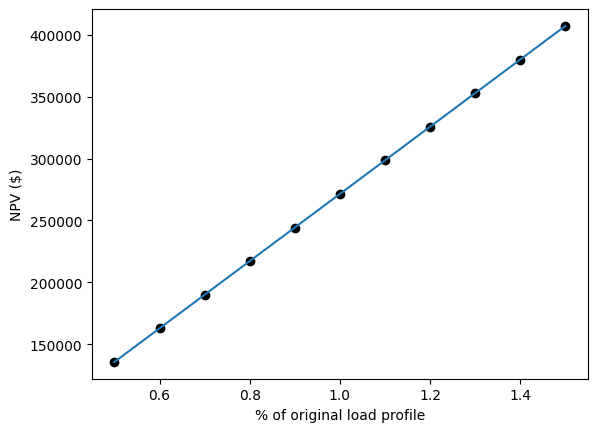

In [263]:
#for loop between 0 and 100 stepping by 10
# Constrain PV and Battery Capacities to be between 1 and 100 kW and kWh respectively
bounds = [(0.1,1000), (0.1,1000)]

initial_guess = [20, 20]

# cp_sensitivity_npv_vals = []

ev_sensitivity_values = []

# # make a list of carbon prices from 0 to 100 stepping by 10
# carbon_prices = np.arange(0, 100, 10)

ev_sensitivity_factor = [0.50, 0.60, 0.70, 0.80, 0.90,  1.1, 1.2, 1.3, 1.4, 1.5, 1.0]

for factor in ev_sensitivity_factor:
    
    a['load_profile'] = load_profile * ev_sensitivity_factor 

    # Optimize
    result = minimize(optimization.objective_function_with_solar_and_battery_degradation_loan, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

    # Extract the optimal capacity
    optimal_pv_capacity = result.x[0]
    optimal_battery_capacity = result.x[1]
    
    max_npv = result.fun 
    
    ev_sensitivity_values.append(-max_npv)

plt.plot(ev_sensitivity_factor, ev_sensitivity_values)
plt.xlabel("% of original load profile")
plt.ylabel("NPV ($)")
#put a dot on each point 
plt.scatter(ev_sensitivity_factor, ev_sensitivity_values, color = 'black')
plt.savefig("figures/ev_load_sensitivity.png")
plt.show()

#### Solar PV output profile 

/Users/Orie4416/Desktop/Feasibility Assessment/chullenv/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


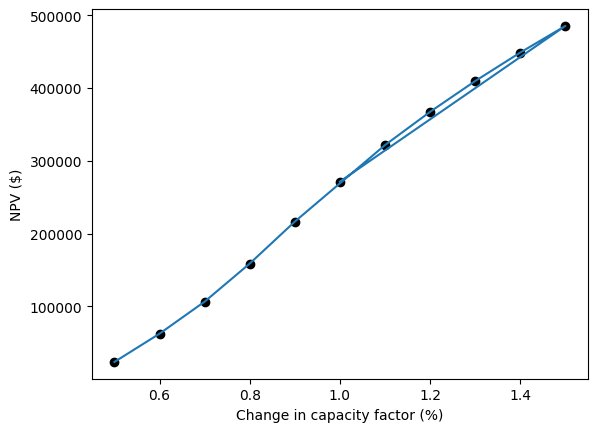

In [269]:
#for loop between 0 and 100 stepping by 10
# Constrain PV and Battery Capacities to be between 1 and 100 kW and kWh respectively
bounds = [(0.1,1000), (0.1,1000)]

initial_guess = [20, 20]

# cp_sensitivity_npv_vals = []

solar_sensitivity_values = []

# # make a list of carbon prices from 0 to 100 stepping by 10
# carbon_prices = np.arange(0, 100, 10)

solar_sensitivity_factors = [0.50, 0.60, 0.70, 0.80, 0.90, 1.1, 1.2, 1.3, 1.4, 1.5, 1.0]

for factor in solar_sensitivity_factors:
    
    a['annual_capacity_factor'] = annual_capacity_factor * factor 

    # Optimize
    result = minimize(optimization.objective_function_with_solar_and_battery_degradation_loan, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

    # Extract the optimal capacity
    optimal_pv_capacity = result.x[0]
    optimal_battery_capacity = result.x[1]
    
    max_npv = result.fun 
    
    solar_sensitivity_values.append(-max_npv)

plt.plot(solar_sensitivity_factors, solar_sensitivity_values)
plt.xlabel("Change in capacity factor (%)")
plt.ylabel("NPV ($)")
#put a dot on each point 
plt.scatter(solar_sensitivity_factors, solar_sensitivity_values, color = 'black')
plt.savefig("figures/pv_output_sensitivity.png")
plt.show()

#### System costs (battery)

In [347]:
battery_cost_sensitivity_factors = [0.5, 0.75, 1, 1.25, 1.5]
target_var_string = 'battery_cost_per_kwh'
target_var_val = battery_cost_per_kwh
battery_cost_sensitivity_df = sensitivity_analysis(target_var_string, target_var_val, battery_cost_sensitivity_factors, a) 



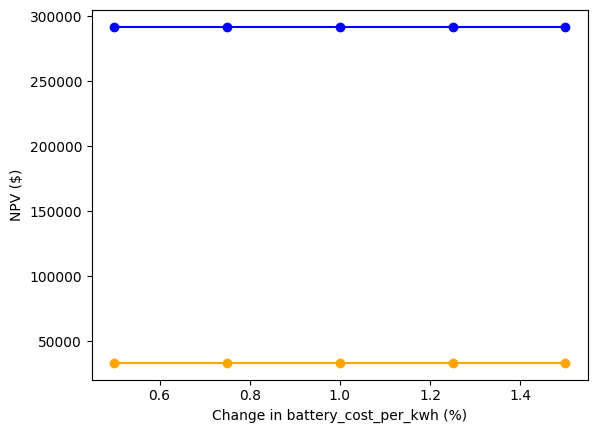

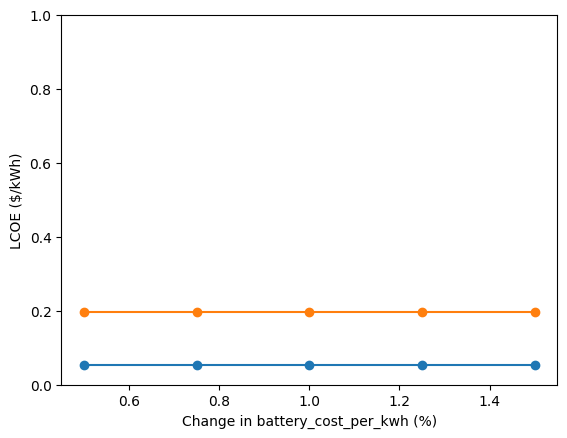

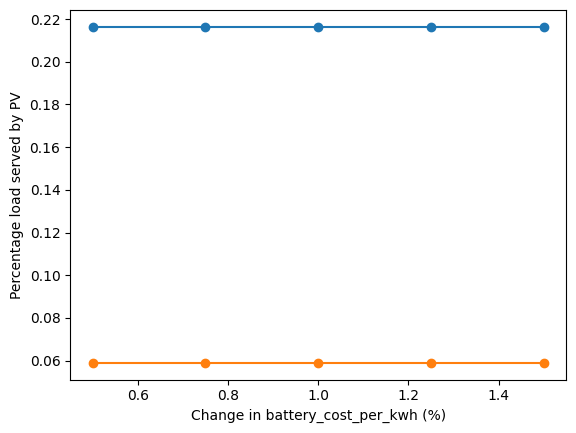

In [351]:
plot_sensitivity(battery_cost_sensitivity_df, target_var_string)

#### System costs (solar PV)

In [352]:
pv_cost_sensitivity_factors = [5.0, 4.0, 3.0, 2.0, 1.0]
target_var_string = 'pv_cost_per_kw'
target_var_val = pv_cost_per_kw

pv_cost_sensitivity_df = sensitivity_analysis(target_var_string, target_var_val, pv_cost_sensitivity_factors, a) 




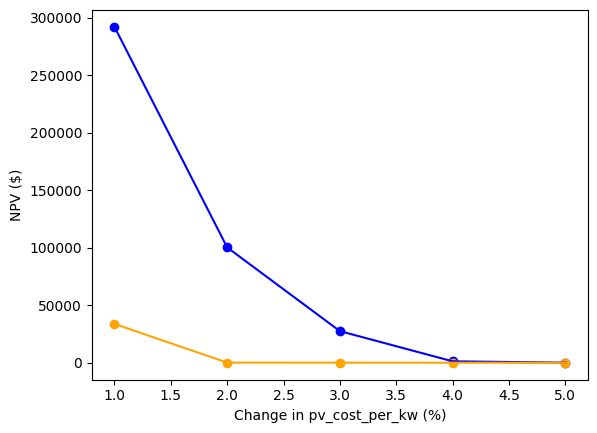

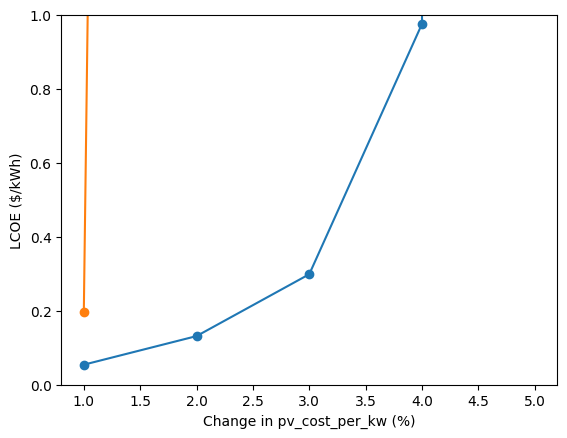

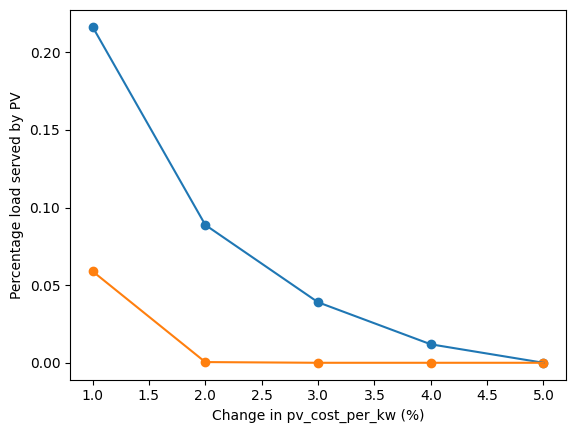

In [353]:
plot_sensitivity(pv_cost_sensitivity_df, target_var_string)

In [276]:

import multiprocessing
sens_fac_1 = [1.25, 1.50]
sens_fac_2 = [1.75, 2.0]
sens_fac_3 = [2.25, 2.50]
sens_fac_4 = [2.75, 3.0]

def sensitivity_analysis_wrapper(target_var_string, target_var, sensitivity_factors, a):
    npv_values, pv, batt = sensitivity_analysis(target_var_string, target_var,sensitivity_factors,a)
    return npv_values

with concurrent.futures.ProcessPoolExecutor() as executor:


# p1 = multiprocessing.Process(target = sensitivity_analysis_wrapper, args = ('pv_cost_per_kw', pv_cost_per_kw,
#                     sens_fac_1, a) )



# p2 = multiprocessing.Process(target = sensitivity_analysis_wrapper, args = ('pv_cost_per_kw', pv_cost_per_kw,
#                     sens_fac_2, a))

processes = []
sens_fac_list = [sens_fac_1, sens_fac_2, sens_fac_3, sens_fac_4]
for sens_fac in sens_fac_list:
    p = multiprocessing.Process(target = sensitivity_analysis_wrapper, args = ('pv_cost_per_kw', pv_cost_per_kw,
                    sens_fac, a))
    p.start()
    print("next process")
    processes.append(p)
print('done procssing')
for process in processes:
    process.join()
    
# npv_vals = []
# for process in processes:
#     npv_vals.extend(process.return_value)


# # append npv_values_2 to npv_values_1
# npv_values_all = npv_values_1.extend(npv_values_2)
# sens_fac_all = sens_fac_1.extend(sens_fac_2)

# plt.plot(sens_fac_all, npv_values_all)
# plt.xlabel("Change in pv costs (%)")
# plt.ylabel("NPV ($)")
# #put a dot on each point 
# plt.scatter(sens_fac_all, npv_values_all, color = 'black')
# plt.savefig("figures/pv_cost_sensitivity.png")
# plt.show()

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/Orie4416/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/Orie4416/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'sensitivity_analysis_wrapper' on <module '__main__' (built-in)>


KeyboardInterrupt: 

### Experimenting

Loadshedding penalty

In [ ]:
reload(generate_data)
reload(economic_analysis)
reload(optimization)

# Constrain PV and Battery Capacities to be between 1 and 100 kW and kWh respectively
bounds = [(1,100), (1,100)]
initial_guess = [20, 20]

# Max land area constraint 
constraint = {'type': 'ineq', 'fun': lambda x: a['max_land_area'] - (x[0] * a['pv_m_sq_per_kw'])} # ineq assumes >= 0

# Avoid load shedding constraint - net load affected by loadshedding must equal 0
#constraint = {'type': 'eq', 'fun': lambda x: optimization.avoid_loadshedding(x,a)}


# Optimize
result = minimize(optimization.objective_function_with_loadshedding_penalty, x0 = initial_guess, args = (a,), constraints = constraint, bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery capacity: {:.2f} kWh".format(optimal_battery_capacity))
print("Investment cost: ${:.2f}".format(economic_analysis.calculate_capital_investment(optimal_pv_capacity, optimal_battery_capacity, a)))
print("Net present value (NPV): ${:.2f}".format(-max_npv))

# Constraint value
# constraint_value = constraint['fun'](result.x, a)
# print("Constraint value: {:.2f}".format(constraint_value))

### <font color = 'lightblue'> Investigating business models </font>
1. Loan 
2. PAYS
3. PPA 
4. PPA / FIT


Loan

In [39]:
a['loadshedding_probability']

0.43105022831050227

In [331]:
reload(generate_data)
reload(economic_analysis)
reload(optimization)

# Constrain PV and Battery Capacities to be between 1 and 100 kW and kWh respectively
bounds = [(1,1000), (1,1000)]
initial_guess = [20, 20]

# Optimize
result = minimize(optimization.objective_function_for_loan, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Maximum NPV: ${:.2f}".format(-max_npv))

# Constraint value
# constraint_value = constraint['fun'](result.x, a)
# print("Constraint value: {:.2f}".format(constraint_value))

KeyError: 'additional_pv_capital_cost'

PAYS (I think this pretty much works? However it is yielding boundary condition battery. Think about why... Might need to play around with the input assumptions to get something)

In [ ]:
reload(optimization)
reload(generate_data)
reload(economic_analysis)
# pays_capital_adjustment = 0.80 # 30% of capital cost paid upfront
# #pays_payback_period = 10 # 10 years for the solar PV system provider to fully recoup their costs
# #pays_annual_interest_rate = 0.05 # 5% annual interest rate
# pays_cut_of_savings = 0.50 # 50% of savings go to the solar PV system provider


# Constrain PV and Battery Capacities between min and max values
bounds = [(1,1000), (1,1000)]
initial_guess = [20, 20]

#Avoid loadshedding constraint
#constraint = {'type': 'ineq', 'fun': lambda x: optimization.avoid_loadshedding(x,a)} # ineq assumes >= 0
a['max_land_area'] = 1890 
# Max land area constraint 
max_land_area_cons = {'type': 'ineq', 'fun': lambda x: a['max_land_area'] - (x[0] * a['pv_m_sq_per_kw'])} # ineq assumes >= 0

# Optimize
result = minimize(optimization.objective_function_PAYS, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Investment cost: ${:.2f}".format(economic_analysis.calculate_capital_investment(optimal_pv_capacity, optimal_battery_capacity, a)))
print("Net present value (NPV) : ${:.2f}".format(-max_npv))


Pyswarm attempt

In [ ]:
import pyswarms as ps
import numpy as np
reload(optimization)
%load_ext autoreload
%autoreload 2 
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

num_particles = 50
num_iterations = 100

# Constrain PV and Battery Capacities between min and max values
lower_bound = 1
upper_bound = 1000
bounds = [(lower_bound,upper_bound), (lower_bound,upper_bound)]

# Initialize swarm with random positions within the search space 
initial_positions = np.random.uniform(lower_bound, upper_bound, (num_particles, 2))


# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=num_particles, dimensions = 2, options=options, bounds=bounds)

# Perform the optimization
best_position, best_fitness = optimizer.optimize(optimization.objective_function_PAYS_PSO, iters=num_iterations,  a = a)

# Print the optimal parameters
print("Optimal PV rating: {:.2f} kW".format(best_position[0]))
print("Optimal battery rating: {:.2f} kWh".format(best_position[1]))

In [ ]:
from deap import base, creator, tools, algorithms
import random


# Define the bounds of the search space
lower_bound = [1, 1]
upper_bound = [100, 100]
bounds = zip(lower_bound, upper_bound)

# Set the parameters for the genetic algorithm
population_size = 50
num_generations = 100

# Create the fitness and individual classes using the DEAP library
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attribute", random.randint, 1, 100)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attribute)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define the evaluation function
def evaluate(individual):
    return (optimization.objective_function_PAYS(individual, a),)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=1, up=100, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Generate the initial population
population = toolbox.population(n=population_size)

# Perform the optimization using the genetic algorithm
result, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=num_generations, verbose=False)

# Extract the best individual from the optimization
best_individual = tools.selBest(result, k=1)[0]

# Extract the optimal capacity
optimal_pv_capacity, optimal_battery_capacity = best_individual

# Calculate the minimum cash flow
max_npv = -best_individual.fitness.values[0]

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Investment cost: ${:.2f}".format(economic_analysis.calculate_capital_investment(optimal_pv_capacity, optimal_battery_capacity, a)))
print("Net present value (NPV): ${:.2f}".format(max_npv))


## Checking battery simulation

In [ ]:
import battery_simulation
reload(battery_simulation)

# Define the battery parameters
battery_capacity = 20 # kWh
battery_power = 5 # kW
battery_efficiency = 0.90 # 90% round-trip efficiency
battery_degradation = 0.001 # 0.1% capacity degradation per cycle


### Enumerative method [checking results]

In [ ]:
# set up a matrix length 100 x 100
npv_matrix = np.zeros((100,100))

npvs = []
pv_sizes = []
battery_sizes = []
# keep track of amount of time 

import time 
start_time = time.time()
for pv_capacity in range(1, 100):
    for battery_capacity in range(1, 100):
        # Decision variables - PV capacity and Battery capacity\
        pv_sizes.append(pv_capacity)
        battery_sizes.append(battery_capacity)

        # Capital Cost of Investment 
        pv_capital_cost =  a['additional_pv_capital_cost'] + a['pv_cost_per_kw'] * pv_capacity ** a['pv_cost_exponent']    # (int) capital cost of PV system 
        battery_capital_cost = a['battery_cost_per_kWh'] * battery_capacity ** a['battery_cost_exponent']   # (int) capital cost of battery
        total_capital_cost = pv_capital_cost + battery_capital_cost

        #### PAYS Business Model ####
        upfront_payment = a['PAYS_capital_cost_adjustment'] * total_capital_cost # (int) upfront payment for panels
        residual_cost_of_panels_owed = total_capital_cost - upfront_payment # (int) residual cost of panels owed

        # Generate PV Output profile 
        pv_output_profile = generate_data.get_pv_output(a['annual_insolation_profile'], a['pv_efficiency'], pv_capacity) 

        # Generate load shedding schedule 
        loadshedding_schedule = generate_data.generate_loadshedding_schedule(a['loadshedding_probability'])

        # Generate PV output profile with battery
        pv_with_battery_output_profile = generate_data.simulate_battery_storage(a['load_profile'], pv_output_profile, battery_capacity, a['battery_duration'],
                                                                                a['battery_charging_efficiency'], a['battery_discharging_efficiency'])
        # Net charging load profile 
        net_load_profile = a['load_profile'] - pv_with_battery_output_profile

        # Profile of kWh that would be lost to load shedding WITHOUT  solar and battery 
        gross_load_affected_by_loadshedding = np.array([a['load_profile'][i] if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)])

        # Profile of kWh that would have been lost to loadshedding but are saved by the solar + battery generation [these are beneficial, and not to be charged $$ for]
        saved_free_kWh = [min(pv_with_battery_output_profile[i], gross_load_affected_by_loadshedding[i]) if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)]

        # Profile of kWh that would be lost to load shedding WITH solar and battery
        net_load_affected_by_loadshedding = np.array([net_load_profile[i] if is_shedding and net_load_profile[i] > 0 else 0 for i, is_shedding in enumerate(loadshedding_schedule)])

        # Find the load profiles that are net of load shedding - this is the load you neeed to charge $ for [in reality you will need an entirely new schedule] 
        gross_load_minus_loadshedding = a['load_profile'] - gross_load_affected_by_loadshedding
        net_load_minus_loadshedding = net_load_profile - net_load_affected_by_loadshedding 

        # Value of kWh saved from loadshedding BY solar + battery!  [makes above not needed?]
        value_of_charging_saved_by_pv_from_loadshedding = economic_analysis.get_cost_of_missed_passengers_from_loadshedding(saved_free_kWh, a['cost_per_passenger'],
                                                                                                a['time_passenger_per_kWh'], a['time_periods'])

        # Energy costs ($ for kWh charged) (net of load shedding - so this is actually cheaper than without loadshedding, but we account for the value of missed trips elsewhere)
        energy_cost_without_pv, energy_cost_with_pv = economic_analysis.get_cost_of_charging(gross_load_minus_loadshedding, net_load_minus_loadshedding,
                                a['time_of_use_tariffs'], a['time_periods'], a['feed_in_tariff'], feed_in_tariff_bool = a['feed_in_tariff_bool'])

        ##### Monetary savings (revenue) from solar + battery #######

        # Carbon
        carbon_savings_per_year = economic_analysis.get_value_of_carbon_offsets(gross_load_minus_loadshedding, net_load_minus_loadshedding, a['grid_carbon_intensity'], a['carbon_price'])

        # Energy  
        energy_savings_per_year = energy_cost_without_pv.sum() - energy_cost_with_pv.sum() # (float) revenue per year from energy savings 

        # Operational
        operational_savings_per_year = value_of_charging_saved_by_pv_from_loadshedding.sum() # (float) revenue per year from saved passengers

        # Total 
        #cash_flows = [energy_savings_per_year + operational_savings_per_year + carbon_savings_per_year for i in range(a['Rproj'])]
            # Payback
        PAYS_payback_per_period = energy_savings_per_year * a['PAYS_cut_of_savings']

        # Revenues TODO: In future versions these will need to be calculated separately for each period, for now assume constant in all periods
        revenues = [energy_savings_per_year + operational_savings_per_year + carbon_savings_per_year for i in range(Rproj)]

        # Costs
        payback_per_period = max(PAYS_payback_per_period, residual_cost_of_panels_owed/Rproj)

        if payback_per_period == residual_cost_of_panels_owed/Rproj:
            num_periods = Rproj
        else: 
            num_periods = 0
            paid_back = 0
            while paid_back < residual_cost_of_panels_owed:
                paid_back += payback_per_period
                num_periods += 1 
            
        costs = np.zeros(len(revenues))

        # Fill the first num_periods elements of costs with PAYS_payback_per_period
        costs[:num_periods] = payback_per_period

        # Adjust the last filled element of cost so that the sum of costs is equal to residual_cost_of_panels_owed
        costs[num_periods - 1] = costs[num_periods - 1] + (residual_cost_of_panels_owed - sum(costs[:num_periods]))
            
        cash_flows = [revenue - cost for revenue,cost in zip(revenues,costs)]

        values = []
        for idx, cash_flow in enumerate(cash_flows):
            this_year_value = cash_flow /(1 + discount_rate)**idx
            values.append(this_year_value)
            
        npv = sum(values) - upfront_payment
        
        npvs.append(npv)
        npv_matrix[pv_capacity][battery_capacity] = npv
        
        # print amount of time elapsed
        current_time = time.time()
        elapsed_time = current_time - start_time
        if elapsed_time > 60:
            print(pv_capacity, battery_capacity)
            start_time = time.time()


In [ ]:
# Plot pv_sizes, battery_sizes, and npvs on a 3D plot, with NPVs on the vertical axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pv_sizes, battery_sizes, npvs, c='r', marker='o')
ax.set_xlabel('PV Size (kW)')
ax.set_ylabel('Battery Size (kWh)')
ax.set_zlabel('NPV ($)')
plt.show()


In [ ]:
# Plot npv_matrix as a 3D surface plot 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(pv_sizes, battery_sizes, npv_matrix)
ax.set_xlabel('PV Size (kW)')
ax.set_ylabel('Battery Size (kWh)')
ax.set_zlabel('NPV ($)')
plt.show()


In [ ]:
# get index of max npv
max_npv = max(npvs)
max_npv_index = npvs.index(max_npv)
print('Max NPV: ', max_npv_index)

In [ ]:
pv_sizes[639], battery_sizes[639]

In [ ]:
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Investment cost: ${:.2f}".format(economic_analysis.calculate_capital_investment(optimal_pv_capacity, optimal_battery_capacity, a)))
print("Savings per year from carbon: ${:.2f}".format(carbon_savings_per_year))
print("Savings per year from energy: ${:.2f}".format(energy_savings_per_year))
print("Savings per year from avoided loadshedding kWh [operational savings]: ${:.2f}".format(operational_savings_per_year))
print("Total savings per year: ${:.2f}".format(carbon_savings_per_year + energy_savings_per_year + operational_savings_per_year))
# pay back $energy savings * 50% per year over N years
print("Under PAYS, pay ${:.2f} up front, then pay back ${:.2f} per year over {} years".format(upfront_payment, max(PAYS_payback_per_period, residual_cost_of_panels_owed/Rproj), len(costs)))
print("Net present value (NPV): ${:.2f}".format(npv))

### <font color = 'lightblue'> Planning for incremental fleet electrification </font>

Goal is to determine how many vehicles can be successfully electrified and run operationally blah blah blah
Ok so how many vehicles can be completely covered by solar + battery...? 
Need to know how big the solar and battery are for that

The optimization problem is to maximize number of vehicles
subject to the constraints of:
budget
land area
no missed loadshedding hours

key assumption is that more vehicles = greater NPV


What is the most amount of energy that would be needed to be covered during load shedding? Make that the minimum battery capacity... ? 
num_vehicles = 20  # Number of EVs in the simulation
charging_power 
max_loadshedding_consecutive_hours

OR num_vehicles * vehicle_battery_size
20 * 7 = 

In [ ]:
schedule = generate_data.generate_loadshedding_schedule(a['loadshedding_probability'], set_random_seed=False)
pv_output_profile = generate_data.get_pv_output(a['annual_insolation_profile'], a['pv_efficiency'], pv_capacity)
pv_with_battery_output_profile = generate_data.simulate_battery_storage(a['load_profile'], pv_output_profile, battery_capacity, a['battery_duration'],
                                                                            a['battery_charging_efficiency'], a['battery_discharging_efficiency'])

### Energy 291 homework example with MIP

In [ ]:
# read excel file Data_Handout.xlsx
df = pd.read_excel('Data_Handout.xlsx', sheet_name='Sheet1')

# Create 

# Split the column into multiple columns
df[['Time', 'Time step', 'WIND-A', 'WIND-B', 'WIND-C', 'Price of power']] = df['Time Time step WIND-A WIND-B WIND-C Price of power'].str.split(' ', expand=True)

df.drop('Time Time step WIND-A WIND-B WIND-C Price of power', axis=1, inplace=True)

# Write df to csv
df.to_csv('Data_Handout.csv', index=False)

In [ ]:
import pandas as pd
from pyomo.environ import *

# Read the data from CSV
PowerData = pd.read_csv("Data_Handout.csv")

OutputA = PowerData["WIND-A"]
OutputB = PowerData["WIND-B"]
OutputC = PowerData["WIND-C"]
PowerPrice = PowerData["Price of power"]
Output = (OutputA + OutputB + OutputC) / 6

POWER = ["WIND-A", "WIND-B", "WIND-C"]
nPOWER = len(POWER)

# Set of time steps
TimeStart = 1
TimeEnd = 432
TIME = list(range(TimeStart, TimeEnd))  # Collect time steps into a list
NumTime = len(TIME)  # Number of time steps

StorageLimit = 100  # MWh
Ccap = 250000  # Capital Cost per MWh ($/MWh capacity)
Lc = 3000  # MWh lifetime stored into battery per MWh of capacity
W = 0.0645  # Round trip losses (MWh/MWh Stored)
T = 432
InitialStorage = 0

# Create a Concrete Model
m = ConcreteModel()

####################################
######## Decision variables ########
####################################

m.StoreIn = Var(range(1, NumTime), domain=NonNegativeReals)  # Output from turbines that is stored in battery
m.StoreOut = Var(range(1, NumTime), domain=NonNegativeReals)  # Amount discharged by battery
m.InStorage = Var(range(1, NumTime + 1), domain=NonNegativeReals)  # Amount in battery storage in next period
m.ToSell = Var(range(1, NumTime), domain=NonNegativeReals)  # Amount sold directly to market

######################################
######## Objective Functions #########
######################################
# Maximize Profit = Revenue - Cost = Revenue from Battery + Revenue from Turbines - Capital Degradation
m.profit = Objective(expr=sum(PowerPrice[t - 1] * (m.ToSell[t] + (1 - W) * m.StoreOut[t]) for t in range(1, NumTime)) - (StorageLimit * Ccap * ((sum(m.StoreOut[t] for t in range(1, NumTime))) / StorageLimit) * (1 / Lc)), sense=maximize)

######################################
############# Constraints ############
######################################

# Storage initialization
m.StorageInit = Constraint(expr=m.InStorage[1] == InitialStorage)

# Storage conservation of energy constraint
m.StorageConservation = ConstraintList()
for t in range(1, NumTime):
    m.StorageConservation.add(m.InStorage[t + 1] == m.InStorage[t] + m.StoreIn[t] - m.StoreOut[t])

# Sufficiency constraint (battery availability constraint)
m.BatteryAvailability = ConstraintList()
for t in range(1, NumTime):
    m.BatteryAvailability.add(m.StoreOut[t] <= m.InStorage[t])

# All power must be sold or stored
m.PowerBalance = ConstraintList()
for t in range(1, NumTime):
    m.PowerBalance.add(Output[t - 1] == m.StoreIn[t] + m.ToSell[t])

# Storage size constraint
m.StorageSize = ConstraintList()
for t in range(1, NumTime):
    m.StorageSize.add(m.InStorage[t] <= StorageLimit)

# Solve the optimization problem
solver = SolverFactory('glpk')
solver.solve(m)



In [ ]:
import pandas as pd
from scipy.optimize import linprog

# Read the data from CSV
PowerData = pd.read_csv("Data_Handout.csv")

OutputA = PowerData["WIND-A"]
OutputB = PowerData["WIND-B"]
OutputC = PowerData["WIND-C"]
PowerPrice = PowerData["Price of power"]
Output = (OutputA + OutputB + OutputC) / 6

POWER = ["WIND-A", "WIND-B", "WIND-C"]
nPOWER = len(POWER)

# Set of time steps
TimeStart = 1
TimeEnd = 432
TIME = list(range(TimeStart, TimeEnd + 1))  # Collect time steps into a list
NumTime = len(TIME)  # Number of time steps

StorageLimit = 100  # MWh
Ccap = 250000  # Capital Cost per MWh ($/MWh capacity)
Lc = 3000  # MWh lifetime stored into battery per MWh of capacity
W = 0.0645  # Round trip losses (MWh/MWh Stored)
T = 432
InitialStorage = 0

# Define the objective function coefficients
c = [-PowerPrice[t] * (1 - W) for t in range(NumTime)]

# Define the constraint matrix
A = [
    [1 if t == i else 0 for t in range(NumTime)] for i in range(NumTime)
]  # Storage conservation of energy constraint

b = [0] * NumTime  # Storage conservation of energy constraint

# Add sufficiency constraint (battery availability constraint)
A += [[0 if t == i else 1 if t == i - 1 else 0 for t in range(NumTime)] for i in range(NumTime)]
b += [0] * NumTime

# Add power balance constraint
A += [
    [1 if t == i else 0 for t in range(NumTime)] for i in range(NumTime)
]  # All power must be sold or stored
b += Output.tolist()

# Add storage size constraint
A += [[0 if t == i else -1 if t == i - 1 else 0 for t in range(NumTime)] for i in range(NumTime)]
b += [0] * NumTime

# Set up the bounds on variables
bounds = [(0, None)] * NumTime

# Solve the linear programming problem
result = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method="highs", options={"presolve": False})

print(result)


In [ ]:
import pulp as pl
import pandas as pd

PowerData = pd.read_csv("Data_Handout.csv")

OutputA = PowerData["WIND-A"]
OutputB = PowerData["WIND-B"]
OutputC = PowerData["WIND-C"]
PowerPrice = PowerData["Price of power"]
Output = (OutputA + OutputB + OutputC) / 6

POWER = ["WIND-A", "WIND-B", "WIND-C"]
nPOWER = len(POWER)

# Set of time steps
TimeStart = 1
TimeEnd = 432
TIME = list(range(TimeStart, TimeEnd + 1))
NumTime = len(TIME)

StorageLimit = 100  # MWh
Ccap = 250000  # Capital Cost per MWh ($/MWh capacity)
Lc = 3000  # MWh lifetime stored into battery per MWh of capacity
W = 0.0645  # Round trip losses (MWh/MWh Stored)
T = 432
InitialStorage = 0

m = pl.LpProblem()

# Decision variables
StoreIn = {t: pl.LpVariable(f"StoreIn_{t}", lowBound=0) for t in TIME}
StoreOut = {t: pl.LpVariable(f"StoreOut_{t}", lowBound=0) for t in TIME}
InStorage = {t: pl.LpVariable(f"InStorage_{t}", lowBound=0) for t in range(1, NumTime + 1)}
ToSell = {t: pl.LpVariable(f"ToSell_{t}", lowBound=0) for t in TIME}

# Objective function
m += (
    pl.lpSum(
        PowerPrice[t - 1] * (ToSell[t] + (1 - W) * StoreOut[t]) for t in TIME
    )
    - StorageLimit
    * Ccap
    * (pl.lpSum(StoreOut[t] for t in TIME) / StorageLimit)
    * (1 / Lc)
)

# Constraints
m += InStorage[1] == InitialStorage
for t in TIME:
    m += InStorage[t + 1] == InStorage[t] + StoreIn[t] - StoreOut[t]
    m += StoreOut[t] <= InStorage[t]
    m += Output[t - 1] == StoreIn[t] + ToSell[t]
    m += InStorage[t] <= StorageLimit

# Solve the problem
m.solve()


In [ ]:
def minimize_unserved_hours(pv_capacity, battery_capacity, load_shedding_schedule, a):
    pv_output_profile = generate_data.get_pv_output(a['annual_insolation_profile'], a['pv_efficiency'], pv_capacity) 
    pv_with_battery_output_profile = generate_data.simulate_battery_storage(a['load_profile'], pv_output_profile, battery_capacity, a['battery_duration'],
                                                                            a['battery_charging_efficiency'], a['battery_discharging_efficiency'])
    net_load_profile = a['load_profile'] - pv_with_battery_output_profile
    unserved_hours = np.array([net_load_profile[i] if net_load_profile[i] < 0 else 0 for i in range(len(net_load_profile))])
    return unserved_hours.sum()

### Plotting sensitivity to loan capital cost adjustment parameters

In [ ]:
vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
reload(optimization)
b,c,d,e,f,g = optimization.plot_sensitivities('loan_upfront_adjustment', vals, bounds, initial_guess, a, optimization.objective_function_for_loan)
h,i,j,k,l,m = optimization.plot_sensitivities('PAYS_capital_cost_adjustment', vals, bounds, initial_guess, a, optimization.objective_function_PAYS)

Check on values of other vars in optimal result

In [ ]:
# Decision variables - PV capacity and Battery capacity 
pv_capacity = result.x[0]
battery_capacity = result.x[1]

# Capital Cost of Investment 
pv_capital_cost =  a['additional_pv_capital_cost'] + a['pv_cost_per_kw'] * pv_capacity ** 1.5   # (int) capital cost of PV system 
battery_capital_cost = a['battery_cost_per_kWh'] * battery_capacity  # (int) capital cost of battery
total_capital_cost = pv_capital_cost + battery_capital_cost

#### PAYS Business Model ####
upfront_payment = a['PAYS_capital_cost_adjustment'] * total_capital_cost # (int) upfront payment for panels
residual_cost_of_panels_owed = total_capital_cost - upfront_payment # (int) residual cost of panels owed

# Generate PV Output profile 
pv_output_profile = generate_data.get_pv_output(a['annual_insolation_profile'], a['pv_efficiency'], pv_capacity) 

# Generate load shedding schedule 
loadshedding_schedule = generate_data.generate_loadshedding_schedule(a['loadshedding_probability'])

# Generate PV output profile with battery
pv_with_battery_output_profile = generate_data.simulate_battery_storage(a['load_profile'], pv_output_profile, battery_capacity, a['battery_duration'],
                                                                        a['battery_charging_efficiency'], a['battery_discharging_efficiency'])
# Net charging load profile 
net_load_profile = a['load_profile'] - pv_with_battery_output_profile

# Profile of kWh that would be lost to load shedding WITHOUT  solar and battery 
gross_load_affected_by_loadshedding = np.array([a['load_profile'][i] if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)])

# Profile of kWh that would have been lost to loadshedding but are saved by the solar + battery generation [these are beneficial, and not to be charged $$ for]
saved_free_kWh = [min(pv_with_battery_output_profile[i], gross_load_affected_by_loadshedding[i]) if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)]

# Profile of kWh that would be lost to load shedding WITH solar and battery
net_load_affected_by_loadshedding = np.array([net_load_profile[i] if is_shedding and net_load_profile[i] > 0 else 0 for i, is_shedding in enumerate(loadshedding_schedule)])

# Find the load profiles that are net of load shedding - this is the load you neeed to charge $ for [in reality you will need an entirely new schedule] 
gross_load_minus_loadshedding = a['load_profile'] - gross_load_affected_by_loadshedding
net_load_minus_loadshedding = net_load_profile - net_load_affected_by_loadshedding 

# Value of kWh saved from loadshedding BY solar + battery!  [makes above not needed?]
value_of_charging_saved_by_pv_from_loadshedding = economic_analysis.get_cost_of_missed_passengers_from_loadshedding(saved_free_kWh, a['cost_per_passenger'],
                                                                                        a['time_passenger_per_kWh'], a['time_periods'])

# Energy costs ($ for kWh charged) (net of load shedding - so this is actually cheaper than without loadshedding, but we account for the value of missed trips elsewhere)
energy_cost_without_pv, energy_cost_with_pv = economic_analysis.get_cost_of_charging(gross_load_minus_loadshedding, net_load_minus_loadshedding,
                        a['time_of_use_tariffs'], a['time_periods'], a['feed_in_tariff'], feed_in_tariff_bool = a['feed_in_tariff_bool'])

##### Monetary savings (revenue) from solar + battery #######

# Carbon
carbon_savings_per_year = economic_analysis.get_value_of_carbon_offsets(gross_load_minus_loadshedding, net_load_minus_loadshedding, a['grid_carbon_intensity'], a['carbon_price'])

# Energy  
energy_savings_per_year = energy_cost_without_pv.sum() - energy_cost_with_pv.sum() # (float) revenue per year from energy savings 


# Operational
operational_savings_per_year = value_of_charging_saved_by_pv_from_loadshedding.sum() # (float) revenue per year from saved passengers

# Total 
#cash_flows = [energy_savings_per_year + operational_savings_per_year + carbon_savings_per_year for i in range(a['Rproj'])]

##### Calculate NPV #####
    # Payback
PAYS_payback_per_period = energy_savings_per_year * a['PAYS_cut_of_savings']

# Revenues TODO: In future versions these will need to be calculated separately for each period, for now assume constant in all periods
revenues = [energy_savings_per_year + operational_savings_per_year + carbon_savings_per_year for i in range(Rproj)]

# Costs
payback_per_period = max(PAYS_payback_per_period, residual_cost_of_panels_owed/Rproj)

num_periods = 0
paid_back = 0
while paid_back < residual_cost_of_panels_owed:
    paid_back += payback_per_period
    num_periods += 1 
    
costs = np.zeros(len(revenues))
# Fill the first num_periods elements of costs with PAYS_payback_per_period
costs[:num_periods] = payback_per_period
# Adjust the last filled element of cost so that the sum of costs is equal to residual_cost_of_panels_owed
costs[num_periods - 1] = costs[num_periods - 1] + (residual_cost_of_panels_owed - sum(costs[:num_periods]))

    
cash_flows = [revenue - cost for revenue,cost in zip(revenues,costs)]

values = []
for idx, cash_flow in enumerate(cash_flows):
    this_year_value = cash_flow /(1 + discount_rate)**idx
    values.append(this_year_value)
    
npv = sum(values) - upfront_payment

npv

In [ ]:
not_covered_kWh = [net_load_profile[i] for i, is_shedding in enumerate(loadshedding_schedule) if is_shedding and net_load_profile[i] > 0]


### Playing with battery optimization models

In [ ]:
import battery_optimization
reload(battery_optimization)

battery_optimization.optimize_battery_energy_flow(a['load_profile'], pv_output_profile, battery_capacity, a['battery_duration'],)

### Todo:
0. Include feed in tariff in the ones with the battery?
0. <font color = 'orange'> Adjust the battery model to prioritize discharge during non-loadshedding hours (we can probably actually optimize the discharge profile since it is known - i.e. optimize it to minimize load shedding hours, or optimize it to minimize total expected cost (including the cost of loadshedding hours)) </font> - <font color = 'lightblue'> Meeting with Becky to discuss </font>
0. <font color = 'lightgreen'> Include capacity (kW) in the battery optimization (speed at which the battery can charge) </font>
2. Include power system gains (voltage stability, reliability?) evaluation, then include that in the objective function somehow... 
    1. include reliability in obj fun?
4. HEADLINE: Numbers or Model???
5. More considerations for optimziation model: Enhance resilience, reduce peak load, reduce loadshedding
    1. Penalty cost for buying during peak hours, penalty cost for resilience violations


1. <font color = 'red'> Options wiht loadshedding: 
    1. Simply evaluate the effect of loadshedding on operations (cost, etc.). Apply a generated loadshedding schedule (assign probability of loadshedding to each hour) to an EV load demand profile, and see how it would shift it if the EV charging operator was blind to the loadshedding before it happened (i.e. they only were able to repsond by charging when power is available).
    2. Optimize the battery storage around predicted loadshedding? 
    3. Use the EVs as storage devices as well (in tandem with the battery - could do this with Brendan)

If model, then I need to probably incldue some shit about loadshedding

IF numbers, then I need really really good dataset and the model needs to be highly accuraet